# **Data Challenge : Predicting weekly Covid incidence based on google searchs in France**


## Data importation


In [1]:
input_path = "data/inputs/"
output_path = "data/outputs/"
work_path = "data/work/"

In [2]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# import packages
from datetime import datetime,timedelta
import pandas as pd
from os import path
import time
import sys
from pytrends.request import TrendReq
#from google.colab import drive (we used that to sync our google drive to the google colab)
import re

In [4]:
pd.set_option('display.max_columns', None)

Using Google Drive to use the data at : /content/drive/MyDrive/data_challenge/data/




In [9]:
# Syncing the google drive

#drive.mount('/content/drive')


### Google trends requesting

No need to run the data extraction : all the raw inputs extracted from data.gouv as well as google search queries are already in data/inputs. You can start running the code at the Data Analysis part.

In [5]:
# keywords:
colnames = ["keywords"]
# Function pd.read_csv reads a comma-separated values (csv) file into DataFrame.
keywords = pd.read_csv(f"{input_path}keyword_list.csv", names=colnames)

keywords = keywords["keywords"].values.tolist()[1:]

print("We are going to request google trend for the following keywords:\n"+", ".join(keywords))

# dateframe:
dateframe = "2020-05-01 2022-05-01"
print(f"Between {dateframe.split(' ')[0] } and {dateframe.split(' ')[1]}")
# codes regions:
reg = 'ABCDEFGHIJKLMNOPQRSTUV'


We are going to request google trend for the following keywords:
angine, avoir du mal a respirer, consience alteree, consience altérée, coronavirus, coronavirus symptomes, coronavirus symptômes, covid, covid 19, covid 19 symptomes, covid 19 symptômes, covid symptomes, covid symptômes, covid-19, covid-19 symptomes, covid-19 symptoms, covid-19 symptôms, covid19, covid19 symptomes, covid19 symptômes, diarhee, diarhée, diarrhee, diarrhée, difficulte respiratoire, difficulte respirer, difficultees respiratoire, difficulté respiratoire, difficulté respirer, difficultées respiratoire, douleur articulaire, epuisement, eruption cutanee, essoufflement, eternuement, eternuer, etre a bout de souffle, etre essouffle, etre essoufflé, fatigue, fatiguer, fatigué, fievre, fièvre, frissoner, frissons, gene respiratoire, gêne respiratoire, haute temperature, haute température, irritation, irritations, joint aching, mal de gorge, mal de tete, mal de tête, maux de gorge, maux de tete, maux de tête, migrain

In [5]:
def get_nat_trends(kw_list=keywords,dateframe = "2020-05-01 2022-05-01"):

  # different headers that will allow not to get blocked by the google bot
    user_agents = [
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36",
        "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0",
        "Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",
        "Mozilla/5.0 (Linux; Android 10; SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.91 Mobile Safari/537.36"
    ]

    def get_trend_req(user_agent_index):
    # function that changes the header
        requests_args = {
            'headers': {
                'User-Agent': user_agents[user_agent_index]
            }
        }
        return TrendReq(requests_args=requests_args, geo="FR")


    # loop to request the api
    df = pd.DataFrame()
    user_agent_index = 0

    for kw in kw_list:
        while True:
            try:
                trends = get_trend_req(user_agent_index)
                trends.build_payload([kw], timeframe=dateframe)
                interest_over_time = trends.interest_over_time()
                if len(interest_over_time)==0:
                    print(f"Probleme : {kw}")

                else:
                    df[kw] = interest_over_time[kw]
                    print(kw)
                break
            except Exception as e:
                print(f"Error for {kw}: {e}")
                user_agent_index = (user_agent_index + 1) % len(user_agents)

    df.to_csv(f"{input_path}NATIONAL_trends.csv")
    return df

def get_reg_trends(kw_list=keywords,regions="ABCDEFGHIJKLMNOPQRSTUV",dateframe="2020-05-01 2022-05-01",prefix=""):
  # different headers that will allow not to geet blocked by the google bot
  user_agents = [
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36",
      "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",
      "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0",
      "Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1",
      "Mozilla/5.0 (Linux; Android 10; SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.91 Mobile Safari/537.36"
  ]

  def get_trend_req(user_agent_index, reg):
    # function that changes the header
      requests_args = {
          'headers': {
              'User-Agent': user_agents[user_agent_index]
          }
      }
      return TrendReq(requests_args=requests_args, geo="FR-"+reg)


  # loop to request the api
  df_reg = {}

  for region in regions:
      df_region = pd.DataFrame()
      user_agent_index = 0

      for kw in kw_list:
          while True:
              try:
                  trends = get_trend_req(user_agent_index, region)
                  trends.build_payload([kw], timeframe=dateframe)
                  interest_over_time = trends.interest_over_time()
                  if len(interest_over_time)==0:
                      print(f"Probleme : {kw}")

                  else:
                      df_region[kw] = interest_over_time[kw]
                      print(kw)
                  break
              except Exception as e:
                  print(f"Error for {region}/{kw}: {e}")
                  user_agent_index = (user_agent_index + 1) % len(user_agents)

      df_region.to_csv(f"{input_path}{prefix}{region}_trends.csv")
      df_reg[region] = df_region
  return df_reg



Running this part is long : all the data from these extractions is already available in the data/inputs folder space.

In [ ]:
# get national trends
get_nat_trends()

# get regional trends for the whole periods
get_reg_trends(regions = 'ABCDEFGHIJKLMNOPQRSTUV',dateframe= "2020-05-10 2022-05-10")

# get regional trends for the period of the learning set
get_reg_trends(regions = 'ABCDEFGHIJKLMNOPQRSTUV',dateframe= "2020-05-10 2021-12-18",prefix="corr_")

### Import and Transform Data

#### df_covid_weekly

In [6]:
# 7 day rolling window data on covid cases at the departemental level
df_covid_weekly = pd.read_csv(f'{input_path}sp-dep-7j-2023-06-30-16h28.csv', delimiter= ';')

print("---Raw df_covid_weekly---")
print(df_covid_weekly.head(3))
print(df_covid_weekly.info())

# Remove the 0 on the dep number to easily merge
df_covid_weekly['dep'] = df_covid_weekly['dep'].str.replace("0","")

# Convert string columns containing values to numeric columns
int_col = ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']
df_covid_weekly[int_col] = df_covid_weekly[int_col].fillna("")
df_covid_weekly[int_col] = df_covid_weekly[int_col].apply(lambda x: x.str.split(",").str[0].astype(int))

# correspondance table between departements and old regions
df_corres = pd.read_csv(f'{input_path}correspondence_table.csv')
df_corres.info()

# merge of covid and corres table on department
df_covid = df_covid_weekly.merge(df_corres, left_on='dep',right_on='Departement',how='left')

# Dropping non numeric columns that are not interesting anymore, and aggregating at the region and date level
df_covid = df_covid.drop(['Departement', 'Departement_label', 'Region_google'], axis = 1).groupby(['sg', 'Code_region_google']).sum().reset_index()

print("---Clean df_covid_weekly---")
print(df_covid_weekly.head(3))
print(df_covid_weekly.info())

# Save clean dataset
df_covid_weekly.to_csv(f'{input_path}df_data_gouv_weekly_v2.csv')

---Raw df_covid_weekly---
  dep                     sg        pop      P        T    Ti    Tp      Td  \
0  01  2020-05-07-2020-05-13  656955,00   9,00   340,00  1,37  2,65   51,75   
1  01  2020-05-08-2020-05-14  656955,00  18,00   777,00  2,74  2,32  118,27   
2  01  2020-05-09-2020-05-15  656955,00  23,00  1230,00  3,50  1,87  187,23   

   cl_age90  
0         0  
1         0  
2         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118626 entries, 0 to 118625
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   dep       118626 non-null  object
 1   sg        118626 non-null  object
 2   pop       118626 non-null  object
 3   P         118626 non-null  object
 4   T         118626 non-null  object
 5   Ti        118626 non-null  object
 6   Tp        118626 non-null  object
 7   Td        118626 non-null  object
 8   cl_age90  118626 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 8.1+ MB
None
<class 

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15980\2976822702.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_covid = df_covid.drop(['Departement', 'Departement_label', 'Region_google'], axis = 1).groupby(['sg', 'Code_region_google']).sum().reset_index()


#### Trend datadrames

In [7]:
# regional trend data concatenation
def df_reg_load(prefix=""):
  reg = 'ABCDEFGHIJKLMNOPQRSTUV'
  df_reg = {f"{region}": pd.read_csv(f"{input_path}{prefix}{region}_trends.csv") for region in reg}

  for reg in df_reg.keys():
    df_reg[reg].date = df_reg[reg].date.apply(
        lambda x: x + "-" + (datetime.strptime(x,"%Y-%m-%d")+ timedelta(days=6)).date().__str__())
    df_reg[reg]['region'] = reg

  df = pd.concat([df_reg[key] for key in df_reg.keys()])
  return df

df = df_reg_load()
df_corr = df_reg_load("corr_")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310 entries, 0 to 104
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     2310 non-null   object 
 1   angine                   1155 non-null   float64
 2   coronavirus              2310 non-null   int64  
 3   coronavirus symptomes    2310 non-null   int64  
 4   coronavirus symptômes    2310 non-null   int64  
 5   covid                    2310 non-null   int64  
 6   covid 19                 2310 non-null   int64  
 7   covid 19 symptomes       2310 non-null   int64  
 8   covid 19 symptômes       2310 non-null   int64  
 9   covid symptomes          2310 non-null   int64  
 10  covid symptômes          2310 non-null   int64  
 11  covid-19                 2310 non-null   int64  
 12  covid-19 symptomes       1575 non-null   float64
 13  covid19                  2310 non-null   int64  
 14  diarhee                  

In [8]:
# national trend data transformation
df_france = pd.read_csv(f'{input_path}NATIONAL_trends.csv')
df_france['date'] = df_france['date'].apply(
    lambda x: x + "-" + (datetime.strptime(x, "%Y-%m-%d") + timedelta(days=6)).date().__str__()
)

### Merge Data

Merge the two dataframes and recompute Ti (positive tests for 100 000 inhabitants)


In [9]:
# for the df
df = df_covid.merge(df, left_on=['sg', 'Code_region_google'], right_on = ['date', 'region'])
df['Ti'] = (df['P']/df['pop'])*100000
df.to_csv(f'{work_path}df_data_merged.csv')

In [10]:
# for the corr_df
df_corr = df_covid.merge(df_corr, left_on=['sg', 'Code_region_google'], right_on = ['date', 'region'])
df_corr['Ti'] = (df_corr['P']/df_corr['pop'])*100000
df_corr.to_csv(f'{work_path}corr_df_data_merged.csv')

In [11]:
# for df_france
df_france = df_covid_weekly.merge(df_france, left_on = ['sg'], right_on = ['date'])
df_france.drop(['sg'], axis = 1, inplace=True)
df_france = df_france.groupby('date').sum()
df_france.to_csv(f'{work_path}df_data_merged_france.csv')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_15980\477354514.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_france = df_france.groupby('date').sum()


## Data Analysis

You can start running the code here.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
df = pd.read_csv(f'{work_path}df_data_merged.csv')

Evolution of some keywords searches over time

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\4047710232.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\4047710232.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\4047710232.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(


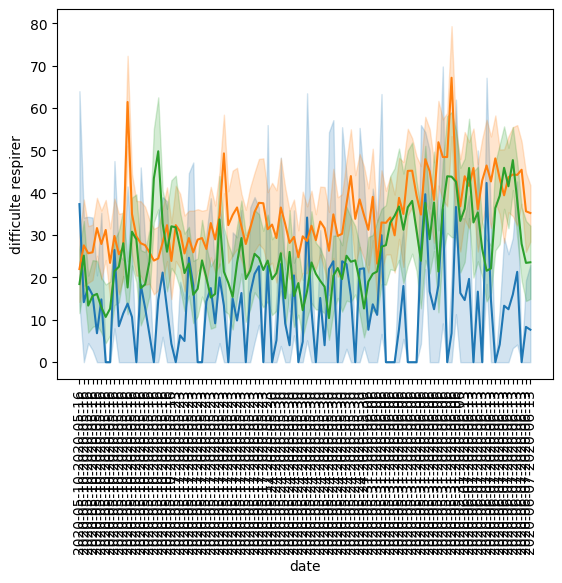

In [7]:
keywords_used = list(set(keywords) & set(df.columns.values))

for kw in keywords_used[0:3]:
    g = sb.lineplot(
        df.loc[df.region == "A"],
        x=df["date"],y=df[kw])
    g.set_xticklabels(
        labels = list(df['date']),
        rotation = 90
    )

<AxesSubplot: >

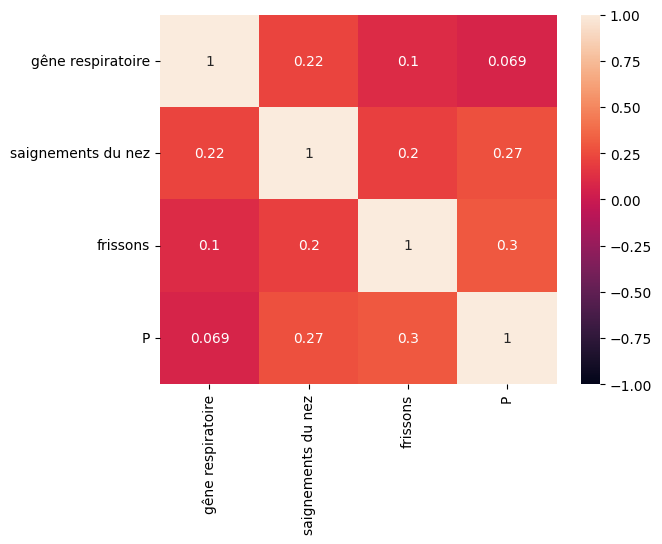

In [9]:
sb.heatmap(df[keywords_used[0:3]+["P"]].corr(), vmin=-1, vmax=1, annot=True)

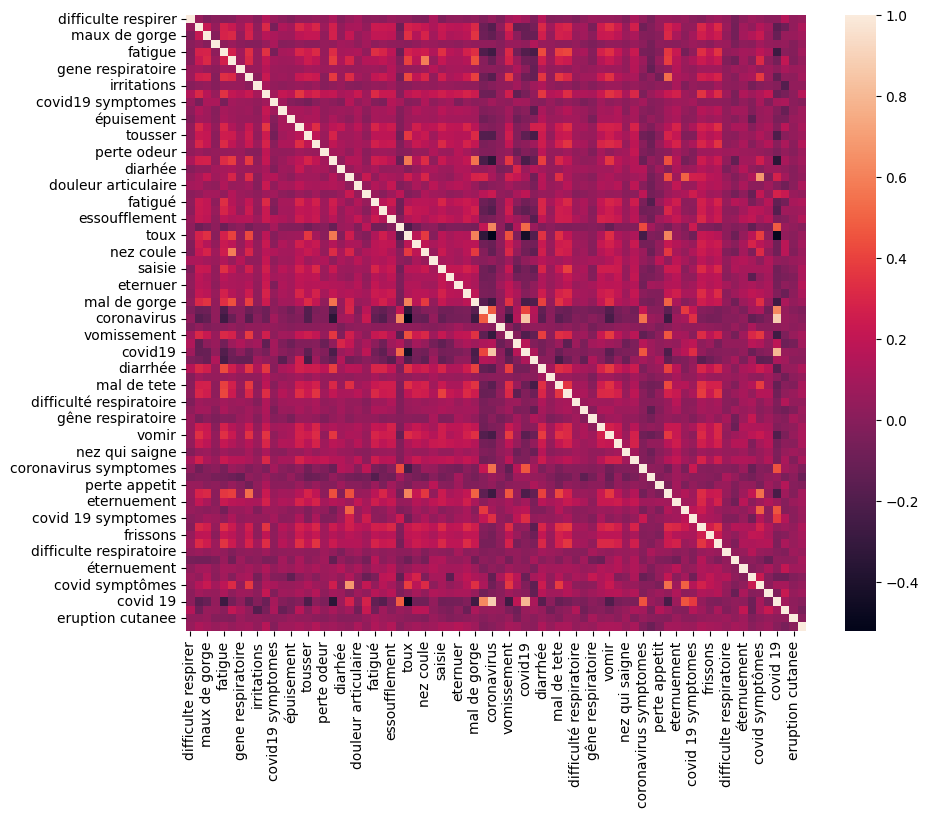

In [8]:
plt.figure(figsize=(10, 8))
heatmap = sb.heatmap(df[keywords_used].corr())

plt.savefig(f'{output_path}kw_corr.png', bbox_inches='tight')
plt.show()

Extracting the different covid waves from the data

In [9]:
# Most frequent word by region during the entire period under study, and segmenting per periods
def get_max_keyword_and_count(df, keywords):
    max_keyword_per_region = df.groupby('region').sum()[keywords].T.idxmax(axis=0)
    max_count_per_region = df.groupby('region').sum()[keywords].T.max(axis=0)

    result = pd.DataFrame({
        'Keyword': max_keyword_per_region,
        'Count': max_count_per_region
    })

    result.reset_index(inplace=True)
    return result

# Different Covid Waves in France
df_second_wave = df[275:308]
df_third_wave = df[517:539]
df_fourth_wave = df[704:737]
df_fifth_wave = df[1936:1958]
df_sixth_wave = df[2156:2178]

result_full_period = get_max_keyword_and_count(df, keywords_used)
result_sw = get_max_keyword_and_count(df_second_wave, keywords_used)
result_tw = get_max_keyword_and_count(df_third_wave, keywords_used)
result_fw = get_max_keyword_and_count(df_fourth_wave, keywords_used)
result_fiw = get_max_keyword_and_count(df_fifth_wave, keywords_used)
result_siw = get_max_keyword_and_count(df_sixth_wave, keywords_used)


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\1720034067.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_keyword_per_region = df.groupby('region').sum()[keywords].T.idxmax(axis=0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\1720034067.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  max_count_per_region = df.groupby('region').sum()[keywords].T.max(axis=0)
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_8036\1720034067.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either spe

Plotting the most frequent words for :
- The whole period (2 years) ;
- The second Covid wave (November 2020) ;
- The third Covid wave (Avril 2021) ;
- The fourth Covid wave (August 2021) ;
- The fifth Covid wave (January 2022) ;
- The sixth Covid wave (March 2022)

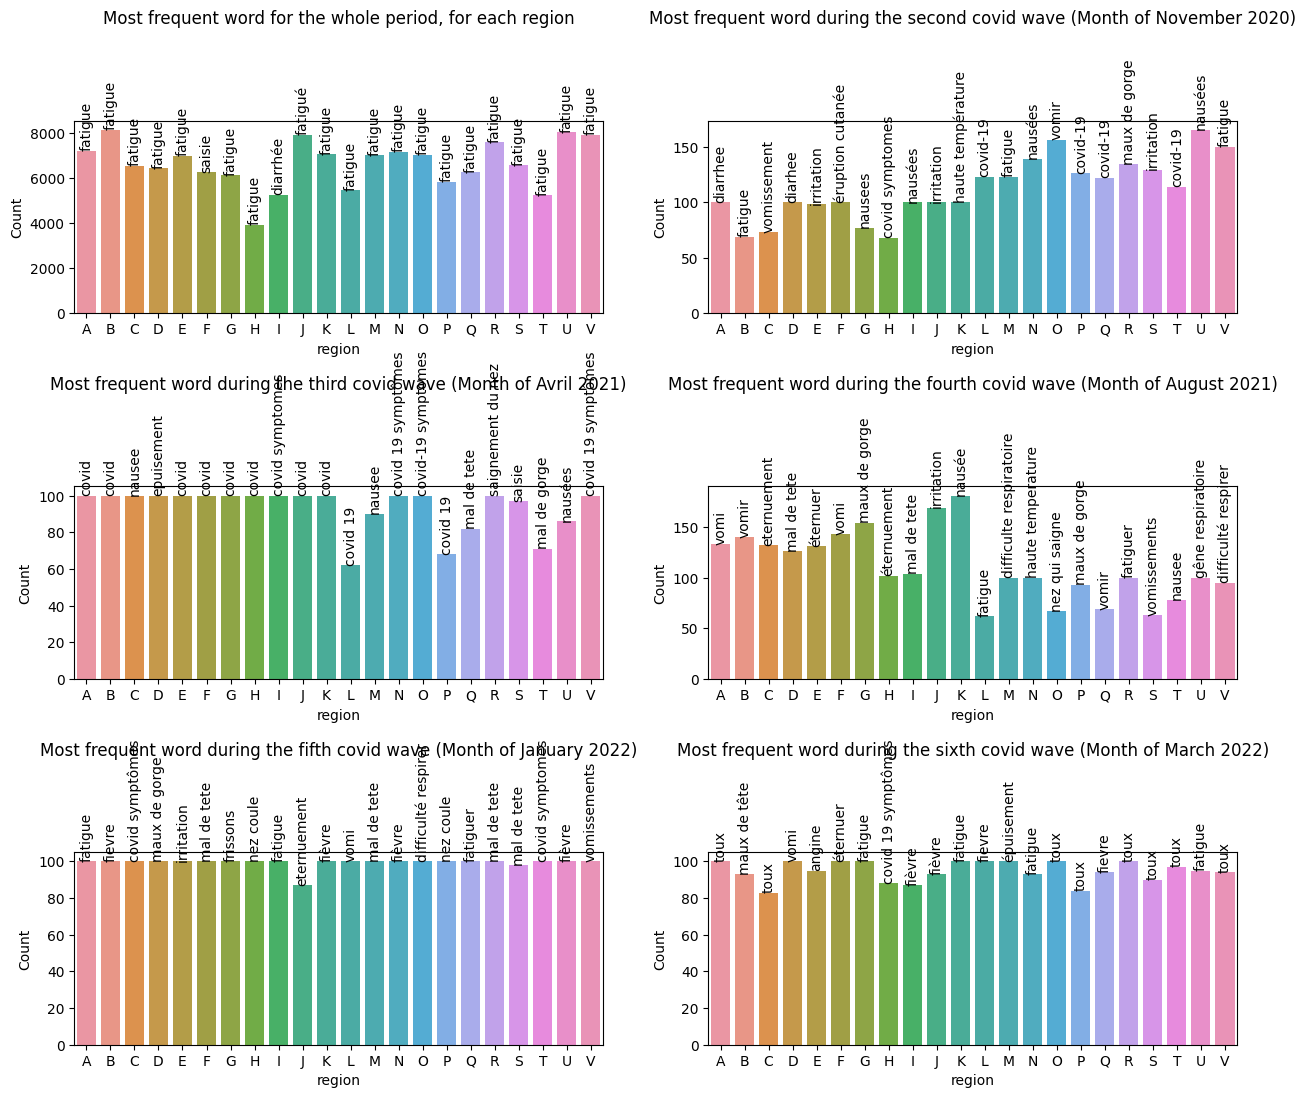

In [10]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,12))
sb.barplot(result_full_period, x = 'region', y = 'Count', ax=ax1)
ax1.set_title('Most frequent word for the whole period, for each region', pad=70)
sb.barplot(result_sw, x = 'region', y = 'Count', ax=ax2)
ax2.set_title('Most frequent word during the second covid wave (Month of November 2020)', pad=70)
sb.barplot(result_tw, x = 'region', y = 'Count', ax=ax3)
ax3.set_title('Most frequent word during the third covid wave (Month of Avril 2021)', pad=70)
sb.barplot(result_fw, x = 'region', y = 'Count', ax=ax4)
ax4.set_title('Most frequent word during the fourth covid wave (Month of August 2021)', pad=70)
sb.barplot(result_fiw, x = 'region', y = 'Count', ax=ax5)
ax5.set_title('Most frequent word during the fifth covid wave (Month of January 2022)', pad=70)
sb.barplot(result_siw, x = 'region', y = 'Count', ax=ax6)
ax6.set_title('Most frequent word during the sixth covid wave (Month of March 2022)', pad=70)

for p,kw in zip(ax1.patches, result_full_period['Keyword']):
    ax1.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)
for p,kw in zip(ax2.patches, result_sw['Keyword']):
    ax2.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)
for p,kw in zip(ax3.patches, result_tw['Keyword']):
    ax3.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)
for p,kw in zip(ax4.patches, result_fw['Keyword']):
    ax4.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)
for p,kw in zip(ax5.patches, result_fiw['Keyword']):
    ax5.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)
for p,kw in zip(ax6.patches, result_siw['Keyword']):
    ax6.annotate(kw, xy=(p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', rotation=90)

fig.subplots_adjust(hspace=0.9)

filename = 'covid_waves.png'
full_path = output_path + filename
plt.savefig(full_path, bbox_inches='tight')

plt.show()

Correlation across time

- How do overall searches for keywords behave across time ?

In [13]:
# Correlation across time

df_reset_index = df.reset_index()
df_reset_index_T = df_reset_index.drop(['pop', 'P', 'T', 'Ti', 'Tp', 'Td', 'cl_age90', 'index'], axis = 1).groupby('date').sum().T
df_reset_index_T.drop(df_reset_index_T.iloc[0].name, inplace=True)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_25920\4275274121.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_reset_index_T = df_reset_index.drop(['pop', 'P', 'T', 'Ti', 'Tp', 'Td', 'cl_age90', 'index'], axis = 1).groupby('date').sum().T


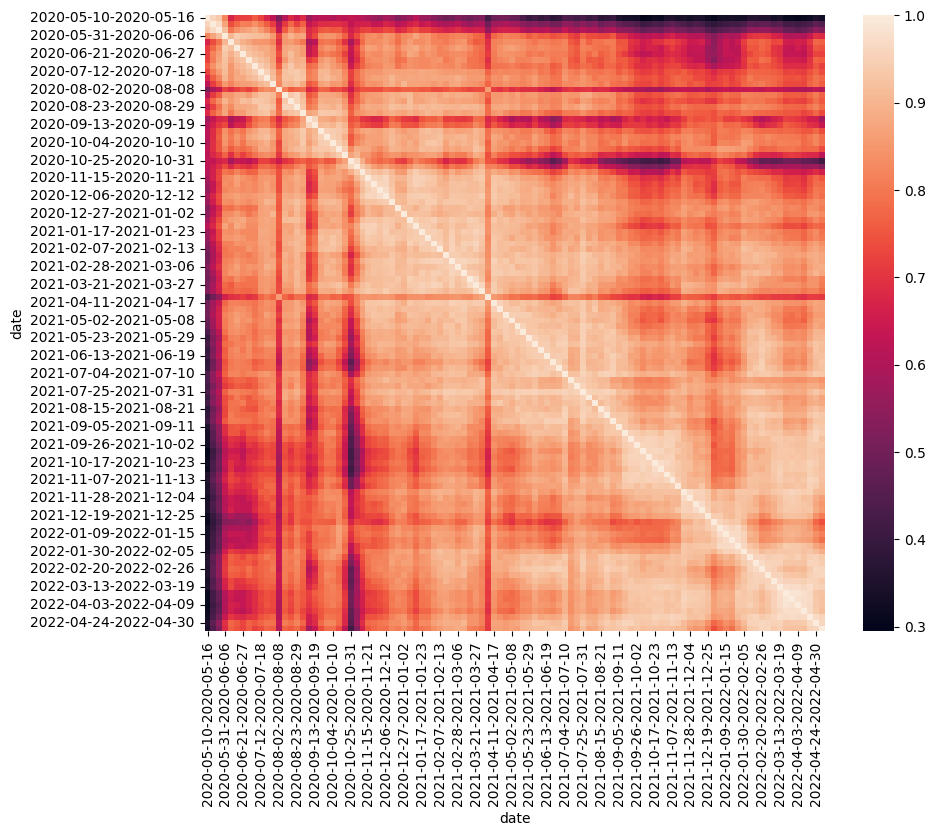

In [14]:
plt.figure(figsize=(10, 8))
heatmap = sb.heatmap(df_reset_index_T.corr())

plt.savefig(f'{output_path}time_corr.png', bbox_inches='tight')
plt.show()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_25920\609204127.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(


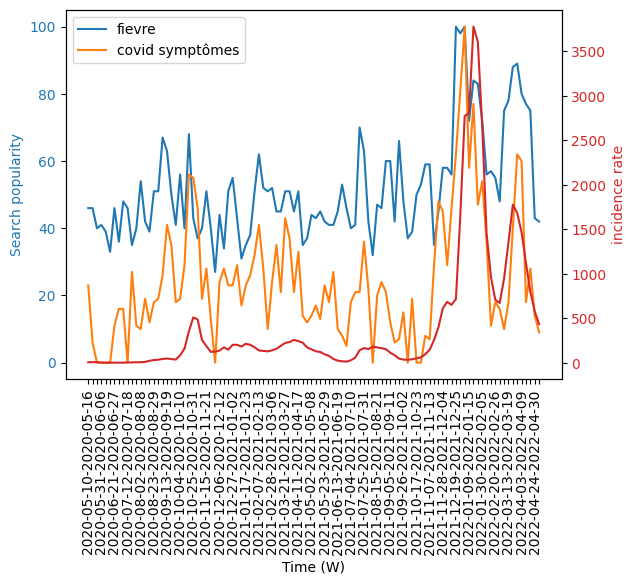

In [15]:
kw_list = ["fievre","covid symptômes"]
region_toplot = "A"
from matplotlib import ticker

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Time (W)')

ax1.set_xticklabels(
        labels = [df.loc[df.region == region_toplot,"date"][i] if i % 3 == 0 else "" for i in df.loc[df.region == region_toplot,'date'].index],
        rotation = 90)
ax1.set_ylabel('Search popularity', color=color)
ax1.tick_params(axis='y', labelcolor=color)

for kw in kw_list:
    ax1.plot(
        df.loc[df.region == region_toplot,"date"],
        df.loc[df.region == region_toplot,kw])
ax1.legend(kw_list)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('incidence rate', color=color) 
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(df.loc[df.region == region_toplot,"date"],df.loc[df.region == "A","Ti"], color=color)
plt.grid(axis='x')
plt.savefig(f'{output_path}incidence_rate_cases_2.png', bbox_inches='tight')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


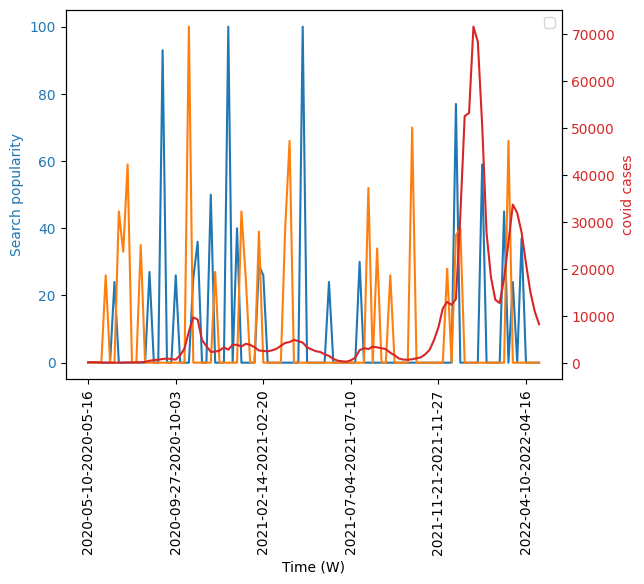

In [16]:
# keywords_used = list(set(keywords) & set(df.columns.values))

df.reset_index(inplace=True)

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Time (W)')
ax1.set_ylabel('Search popularity', color=color)
ax1.tick_params(axis='y', labelcolor=color)

for kw in ["gene respiratoire","perte odeur"]:
    ax1.plot(df.loc[df.Code_region_google == "A","date"], df.loc[df.Code_region_google == "A",kw], label=kw)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('covid cases', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(df.loc[df.Code_region_google == "A","date"], df.loc[df.Code_region_google == "A","P"], color=color)

dates = df.loc[df.Code_region_google == "A", "date"]
ax1.set_xticks(dates[::len(dates)//5]) 
ax1.set_xticklabels(dates[::len(dates)//5], rotation=90)

plt.legend() 

plt.savefig(f'{output_path}popularity_covid.png', bbox_inches='tight')
plt.show()


Visualizing each region incidence rate, emphasizing the different waves present in the data

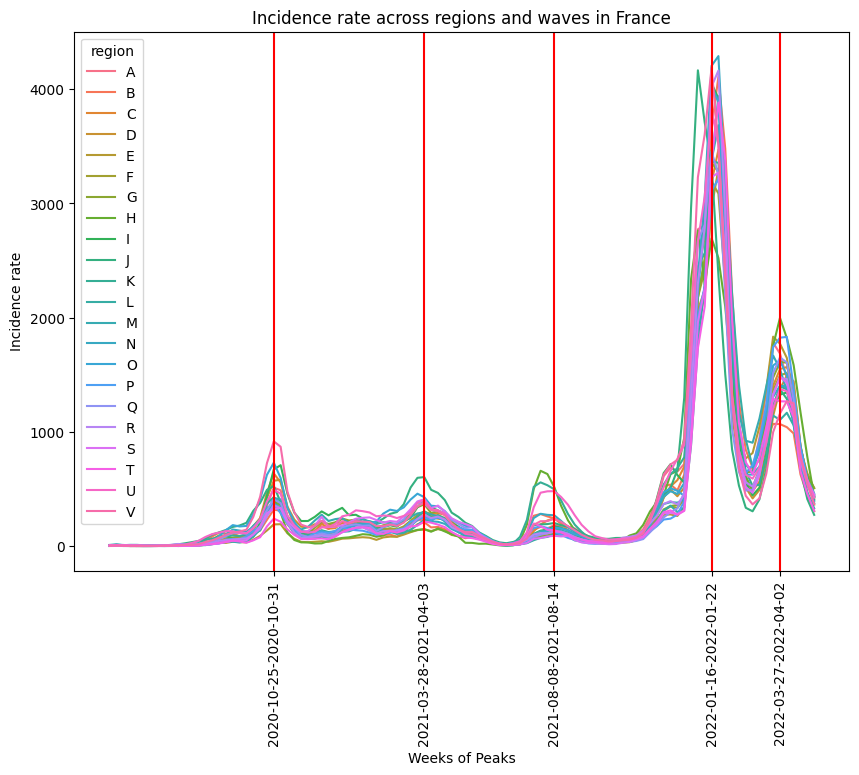

In [17]:
# Visualizing peaks

fig = plt.figure(figsize=(10,7))
g = sb.lineplot(data=df, x='date', y='Ti', hue='region')
g.set_title('Incidence rate across regions and waves in France')

peak_dates = df.groupby('date')['P'].sum().nlargest(40).reset_index()['date']
selected_peak_dates = peak_dates.iloc[[0, 6, 20, 26, 35]]

for date in selected_peak_dates:
    g.axvline(date, color='red')

g.set_xticks(selected_peak_dates)
g.set_xticklabels(selected_peak_dates, rotation=90)

g.set_xlabel('Weeks of Peaks')
g.set_ylabel('Incidence rate')

plt.savefig(f'{output_path}incidence_rate_plot.png', bbox_inches='tight')

plt.show()

Clustering regions :

- Can we find clusters of regions that behaved similarly with respect to the incidence rate over time ?

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [19]:
# Function to remove columns if percentage of missing values is higher than a threshold

def remove_col(df, theshold = 30):
    for col in df.columns:
        if (df[col].isna().sum()/len(df[col]))*100 > theshold:
            df.drop([col], axis = 1, inplace=True)
    return df

In [20]:
# Groupby region and dates

df = pd.read_csv(f'{work_path}df_data_merged.csv')
df_groupby = df.groupby(['date', 'region']).sum().reset_index().set_index('date')

# Pivoting the table to have only Ti values for each region, each region being a timeframe

df_pivot = df_groupby.pivot_table(values='Ti', index='region', columns='date')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_25920\3880672675.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_groupby = df.groupby(['date', 'region']).sum().reset_index().set_index('date')


In [21]:
scaler = StandardScaler()

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_in

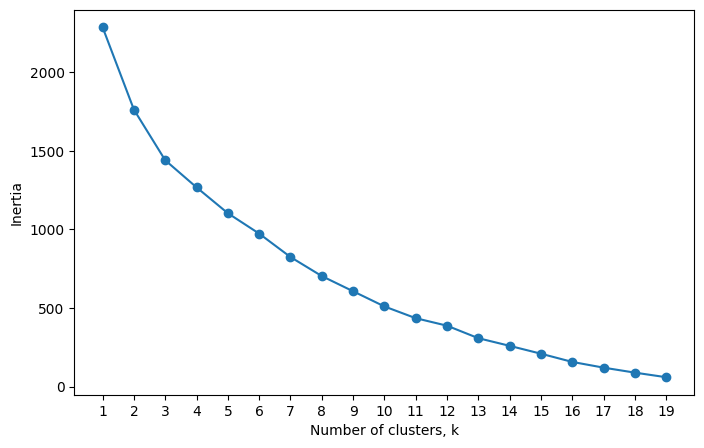

In [22]:
# No need to reduce dimensionality, just scaling

df_scaled = scaler.fit_transform(df_pivot)

# Elbow Method for number of clusters

ks = range(1, 20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k, init = 'k-means++')
    model.fit(df_scaled)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [23]:
# It seems like 4 clusters is a good value

k_means_opt = KMeans(n_clusters=4, init='k-means++')
k_means_opt.fit(df_scaled)
df_pca = pd.DataFrame(df_scaled)
df_pivot['cluster'] = k_means_opt.labels_

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


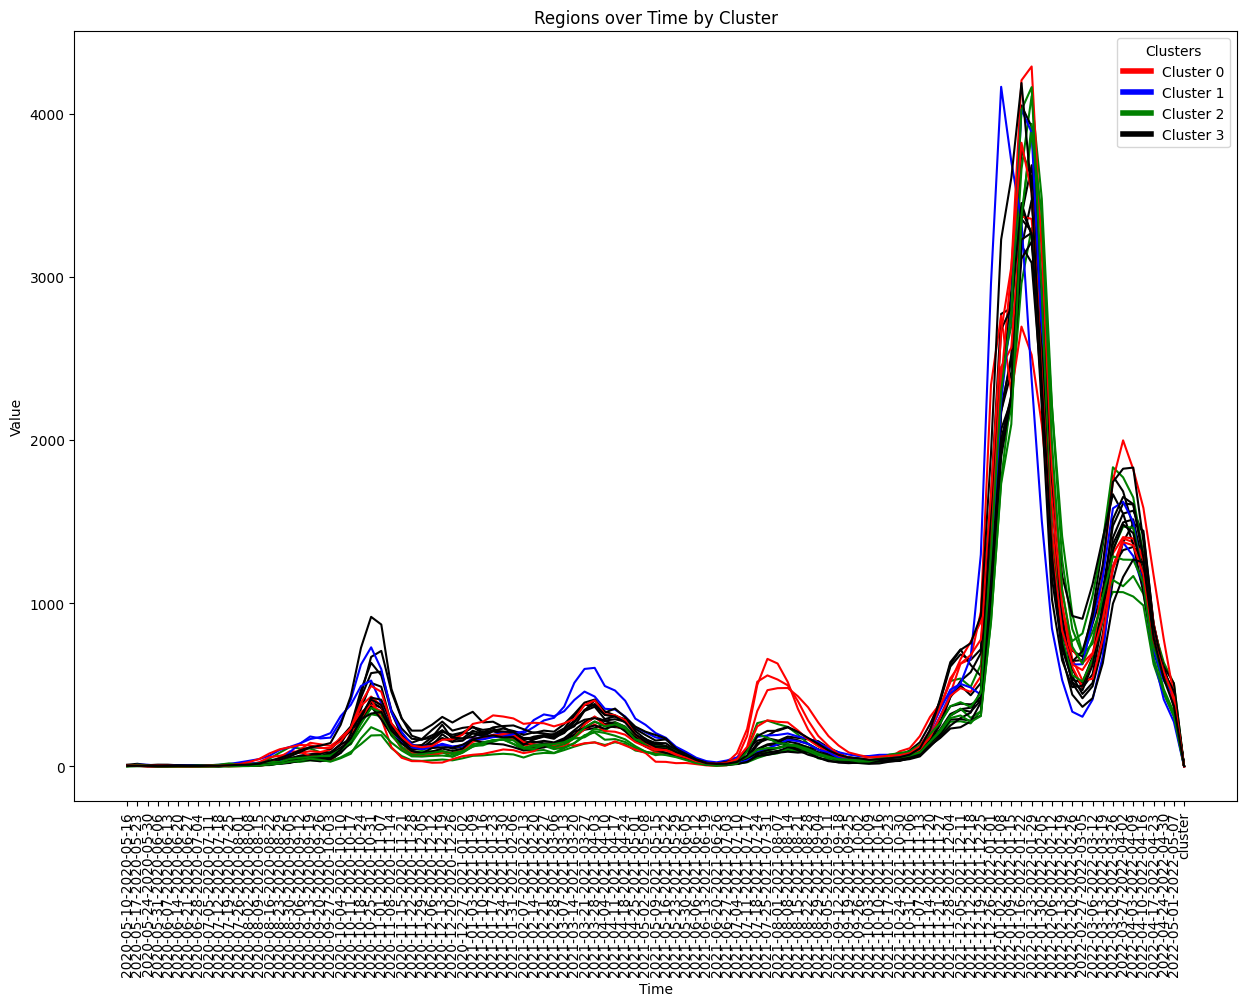

In [24]:
# Visualizing clustering

from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(15, 10))

cluster_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'black'}

for region in df_pivot.index:
    cluster = df_pivot.loc[region, 'cluster']
    ax.plot(df_pivot.columns, df_pivot.loc[region, :], color=cluster_colors[cluster], label=f"Cluster {cluster} - {region}")

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Regions over Time by Cluster')

ax.tick_params(axis='x', rotation=90)
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'Cluster {i}') for i, color in cluster_colors.items()]
ax.legend(handles=legend_elements, title="Clusters")
plt.savefig(f'{output_path}clustering.png', bbox_inches='tight')

plt.show()

Let's study more in depth the distriubtion of the incidence rate variable

In [25]:
import seaborn as sb
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

In [26]:
df = pd.read_csv(f'{work_path}df_data_merged.csv')

<Figure size 1000x600 with 0 Axes>

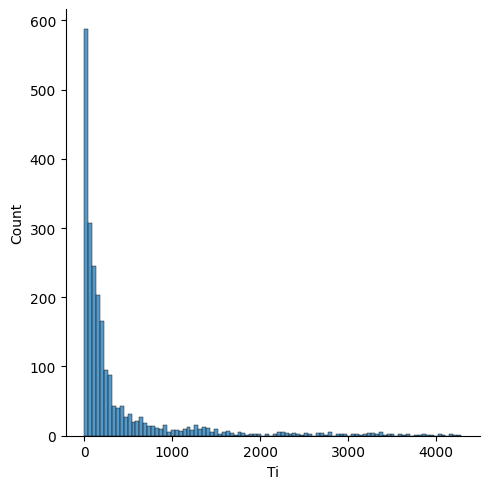

In [27]:
plt.figure(figsize=(10, 6))
sb.displot(df, x='Ti')

plt.savefig(f'{output_path}distplot_Ti.png', bbox_inches='tight')

Clearly, the distribution is right skewed, with a long tail. This suggests a lot of rare observations, much more than in a Gaussian case.

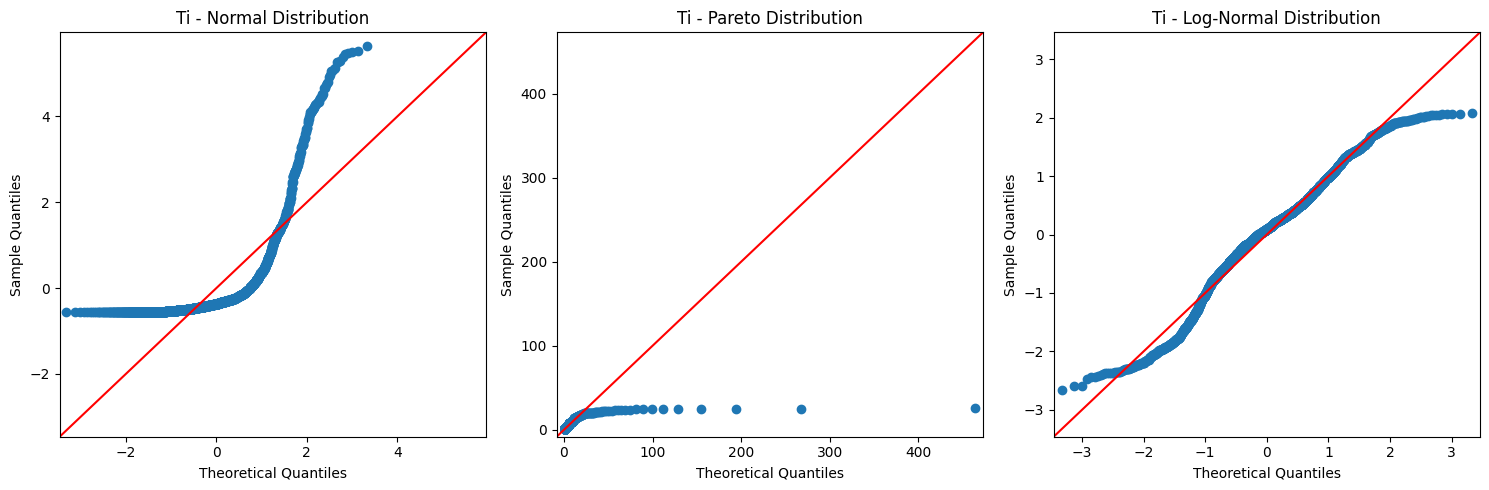

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sm.qqplot(df['Ti'], stats.norm, line='45', fit=True, ax=axes[0])
axes[0].set_title('Ti - Normal Distribution')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

# QQ plot for Pareto Distribution
sm.qqplot(df['Ti'], stats.pareto, line='45', fit=True, ax=axes[1])
axes[1].set_title('Ti - Pareto Distribution')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

# QQ plot for Log-Normal Distribution
logged_data = np.log(df['Ti'] + 1)
logged_data = logged_data[np.isfinite(logged_data)]
sm.qqplot(logged_data, stats.norm, line='45', fit=True, ax=axes[2])
axes[2].set_title('Ti - Log-Normal Distribution')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.savefig(f'{output_path}QQplots.png', bbox_inches='tight')
plt.show()

Visually, the Q-Q Plots tells us that the distribution of the incidence rates are closer to a log-normal distribution than to a Power Law distribution. This means that while the data itself might not be symmetrically distributed, its logarithm is. It would be useful to keep that in mind for further works.

## Modelling

In [11]:
# import packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import pandas as pd
import statsmodels.api as sm
from os import path
import time
import sys
#import statsmodel.api as sm
#from google.colab import drive
import re
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)


In [12]:
# Function to remove columns if percentage of missing values is higher than a threshold

def remove_col(df, theshold = 30):
    for col in df.columns:
      if (df[col].isna().sum()/len(df[col]))*100 > theshold:
          df.drop([col], axis = 1, inplace=True)
    return df

# Shifting the time series

def shifting_series(df, y_var, n_shift=1):
    for col in df.columns:
        if col != y_var:
            df[col] = df[col].shift(n_shift)
    df = df.iloc[n_shift:]
    return df

# Plotting results

def plot_results(regions, results, filename):
    ''' Function to plot the best results obtained for selected regions, with their
     corresponding optimal MSE and keywords lag '''

    n_regions = len(regions)
    if n_regions > 5:
        n_cols = 5
    else:
        n_cols = n_regions
    n_rows = n_regions // n_cols + (n_regions % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    fig.tight_layout(pad=3.0)

    axs = axs.flatten()
    results_mse = {}

    for idx, region in enumerate(regions):
        highest_mse_reg = float('inf')
        highest_mse_reg_lag = 0
        best_test_array = []
        best_pred_array = []
        test_index = []

        for i in range(0, 5):
            current_mse = results[region][i]['mse']
            if current_mse < highest_mse_reg:
                highest_mse_reg = current_mse
                highest_mse_reg_lag = i
                best_test_array = results[region][i]['true']
                best_pred_array = results[region][i]['predictions']
                test_index = results[region][i]['Test_idx']

        results_mse[region] = {'highest mse': highest_mse_reg, 'lag': highest_mse_reg_lag}

        axs[idx].plot(test_index, best_test_array, label='Test')
        axs[idx].plot(test_index, best_pred_array, label='Prediction')
        axs[idx].set_title(f'Region {region}\nBest MSE: {highest_mse_reg:.2f}, Best Lag: {highest_mse_reg_lag+1}')
        axs[idx].legend()

        if len(test_index) > 2:
            first, middle, last = test_index[0], test_index[len(test_index) // 2], test_index[-1]
            axs[idx].set_xticks([first, middle, last])
            labels = axs[idx].get_xticklabels()
            axs[idx].set_xticklabels(labels, rotation=45)

    for i in range(idx + 1, len(axs)):
        axs[i].axis('off')

    # Save the plot
    plt.savefig(f'{output_path}{filename}.png', bbox_inches='tight')
    plt.show()

Importing datasets : regional and national levels

In [13]:
df_france = pd.read_csv(f'{work_path}df_data_merged_france.csv')
df = pd.read_csv(f'{work_path}df_data_merged.csv')
df_corr = pd.read_csv(f'{work_path}corr_df_data_merged.csv')

Preparing the data : adding seasonality component, transforming datasets and lagging each keyword by 1 (today's incidence rate linked with past week's keywords)

In [14]:
season_dic = {1:'winter',2:'spring',3:'summer',4:'autumn'}

# Regional level

df['season'] = (pd.to_datetime(df.date.str[0:10])).apply(lambda x: season_dic[x.month%12 // 3 +1])
df = pd.get_dummies(df,columns=['season'])

df_corr['season'] = (pd.to_datetime(df_corr.date.str[0:10])).apply(lambda x: season_dic[x.month%12 // 3 +1])
df_corr = pd.get_dummies(df_corr,columns=['season'])

# National level
df_france['season'] = (pd.to_datetime(df_france.date.str[0:10])).apply(lambda x: season_dic[x.month%12 // 3 +1])
df_france = pd.get_dummies(df_france,columns=['season'])

In [15]:
def regionalize_df(df):
  # Create a dictionary with df per region
  regions = "ABCDEFGHIJKLMNOPQRSTUV"
  df_reg_cleaned = {region: df.loc[df.region == region] for region in regions}

  for reg in df_reg_cleaned.keys():
      df_reg_cleaned[reg] = df_reg_cleaned[reg].sort_values(
          by=['date'], key=lambda x: pd.to_datetime(x.str[0:10]), ascending=True)
      df_reg_cleaned[reg].set_index('date', inplace=True)
      df_reg_cleaned[reg] = df_reg_cleaned[reg].loc[:,(df_reg_cleaned[reg].select_dtypes(include=np.number).columns)]
      df_reg_cleaned[reg] = remove_col(df_reg_cleaned[reg])
      # Inputting missing values with mean
      df_reg_cleaned[reg].fillna(df_reg_cleaned[reg].mean(), inplace=True)
      # Lag the keywords by one already
      df_reg_cleaned[reg] = shifting_series(df_reg_cleaned[reg], 'Ti')
      # Remove Unnamed: 0 column which is useless, add column for month (account for seasonality)
      x_columns = ['Unnamed: 0', 'pop', 'P', 'T', 'Ti', 'Tp', 'Td', 'cl_age90']
      x_df = df_reg_cleaned[reg].drop(x_columns, axis=1, errors = 'ignore')
      y_df = df_reg_cleaned[reg][['Ti']]

      df_reg_cleaned[reg] = {'x': x_df, 'y': y_df, 'labels': x_df.columns.values}

      print(f"Region {reg} processed with {len(x_df.columns)} explanatory variables")
  return df_reg_cleaned

df_reg_cleaned = regionalize_df(df)
df_corr_reg_cleaned = regionalize_df(df_corr)

Region A processed with 66 explanatory variables
Region B processed with 72 explanatory variables
Region C processed with 62 explanatory variables
Region D processed with 64 explanatory variables
Region E processed with 69 explanatory variables
Region F processed with 67 explanatory variables
Region G processed with 60 explanatory variables
Region H processed with 52 explanatory variables
Region I processed with 61 explanatory variables
Region J processed with 78 explanatory variables
Region K processed with 69 explanatory variables
Region L processed with 51 explanatory variables
Region M processed with 61 explanatory variables
Region N processed with 61 explanatory variables
Region O processed with 64 explanatory variables
Region P processed with 53 explanatory variables
Region Q processed with 61 explanatory variables
Region R processed with 63 explanatory variables
Region S processed with 60 explanatory variables
Region T processed with 59 explanatory variables
Region U processed w

In [16]:
# National data

df_france = df_france.sort_values(
    by=['date'], key = lambda x: pd.to_datetime(x.str[0:10]), ascending = True)
df_france.set_index('date', inplace=True)
df_france = remove_col(df_france.select_dtypes(include=np.number))

Patterns of missing values at the national scale

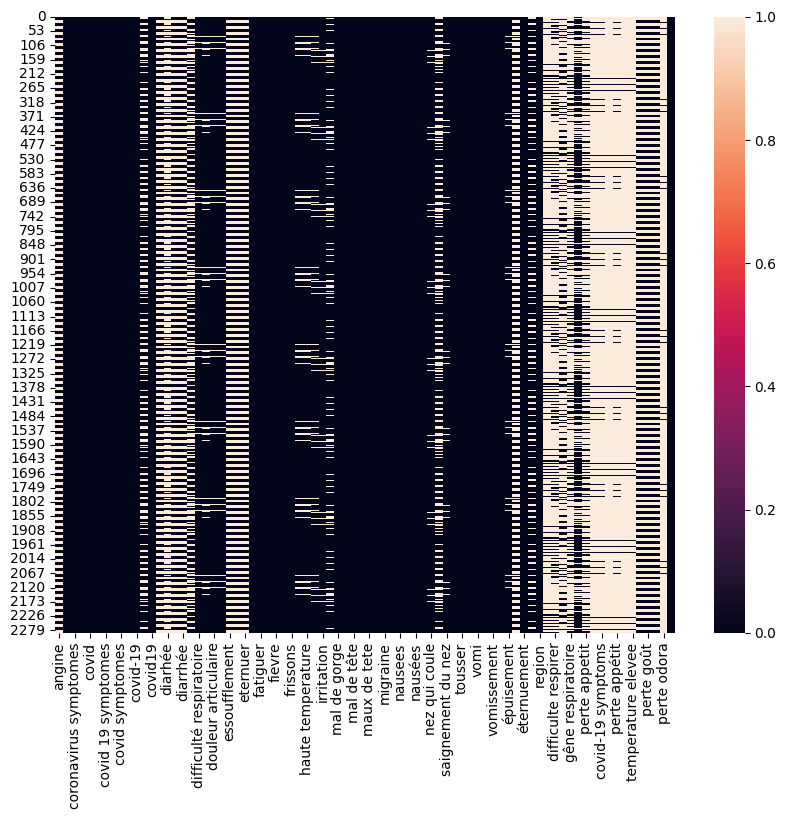

In [17]:
plt.figure(figsize=(10, 8))
heatmap = sb.heatmap(df.drop(['Unnamed: 0', 'pop', 'P', 'T', 'Ti', 'Tp', 'Td', 'cl_age90', 'sg', 'Code_region_google', 'season_winter', 'season_spring', 'season_summer', 'date'], 
                   axis = 1).isna())

plt.savefig(f'{output_path}missingness_national.png', bbox_inches='tight')
plt.show()

In [18]:
df_france.fillna(df_france.mean(), inplace=True)
df_france = shifting_series(df_france, 'Ti')
x_columns = ['Unnamed: 0', 'pop', 'P', 'T', 'Ti', 'Tp', 'Td', 'cl_age90']
x_df = df_france.drop(x_columns, axis=1, errors = 'ignore')
y_df = df_france[['Ti']]

print(f"National Level processed with {len(x_df.columns)} explanatory variables")

National Level processed with 56 explanatory variables


In [19]:
# joining the test set and the learning set values without data leakage
for region in df_reg_cleaned.keys():
  # chooses the columns in common
  col_in_common = list(set(df_reg_cleaned[region]['x'].columns.values).intersection(df_corr_reg_cleaned[region]['x'].columns.values))

  # updates the labels
  df_corr_reg_cleaned[region]['labels'] = col_in_common

  # chooses the dates to test on and saves it
  rows_test = list(set(df_reg_cleaned[region]['x'].index.values).difference(df_corr_reg_cleaned[region]['x'].index.values))
  df_corr_reg_cleaned[region]['test dates'] = rows_test

  # adds the values to test on without data leakage
  df_corr_reg_cleaned[region]['x'] = pd.concat([df_corr_reg_cleaned[region]['x'].loc[:,col_in_common],df_reg_cleaned[region]['x'].loc[rows_test,col_in_common]])
  df_corr_reg_cleaned[region]['y'] = pd.concat([df_corr_reg_cleaned[region]['y'],df_reg_cleaned[region]['y'].loc[rows_test]])

Additional test : Stationarity of Ti (incidence rates) time series (Adfuller test of stationarity) and presence of autoregressive component (mainly : PACF)

AdFuller Test :

- H0 : The series is non stationary
- HA : The series is stationary

In [38]:
def reg_stationarity_acf_pacf(df_reg_cleaned, filename):
    num_regions = len(df_reg_cleaned.keys())

    fig, axs = plt.subplots(num_regions, 4, figsize=(20, num_regions * 4))

    for i, region in enumerate(df_reg_cleaned.keys()):
        series = np.array(df_reg_cleaned[region]['y']).ravel()
        adf_result = sm.tsa.stattools.adfuller(series, regression='c', autolag='BIC')
        axs[i, 0].annotate(f'Original ADF p-value: {adf_result[1]:.4f}', xy=(0.5, -0.15), xycoords='axes fraction', ha='center')

        sm.graphics.tsa.plot_acf(series, ax=axs[i, 0])
        axs[i, 0].set_title(f'ACF for {region}')
        sm.graphics.tsa.plot_pacf(series, ax=axs[i, 1])
        axs[i, 1].set_title(f'PACF for {region}')

        if adf_result[1] > 0.05:
            series_diff = np.diff(series)
            adf_result_diff = sm.tsa.stattools.adfuller(series_diff, regression='c', autolag='BIC')

            sm.graphics.tsa.plot_acf(series_diff, ax=axs[i, 2])
            axs[i, 2].set_title(f'Differenced ACF for {region}')
            sm.graphics.tsa.plot_pacf(series_diff, ax=axs[i, 3])
            axs[i, 3].set_title(f'Differenced PACF for {region}')

            axs[i, 2].annotate(f'Diff ADF p-value: {adf_result_diff[1]:.4f}', xy=(0.5, -0.15), xycoords='axes fraction', ha='center')
        else:
            axs[i, 2].set_visible(False)
            axs[i, 3].set_visible(False)

    plt.tight_layout()
    plt.savefig(f'{output_path}{filename}.png', bbox_inches='tight')
    plt.show()

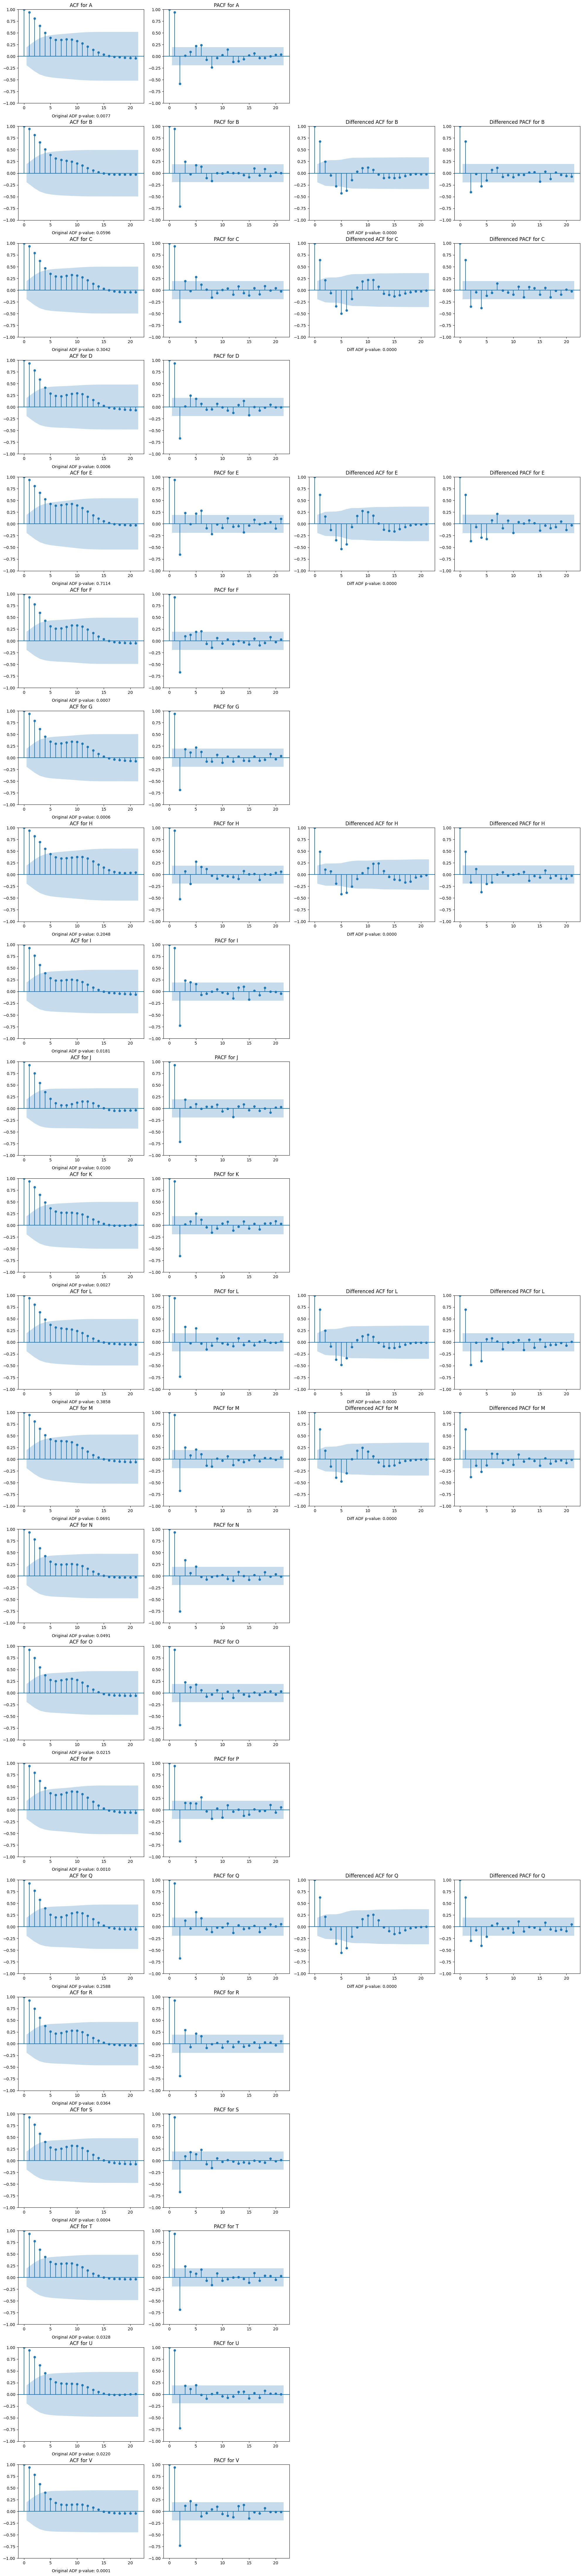

In [39]:
reg_stationarity_acf_pacf(df_reg_cleaned, 'acf_pacf_regions')

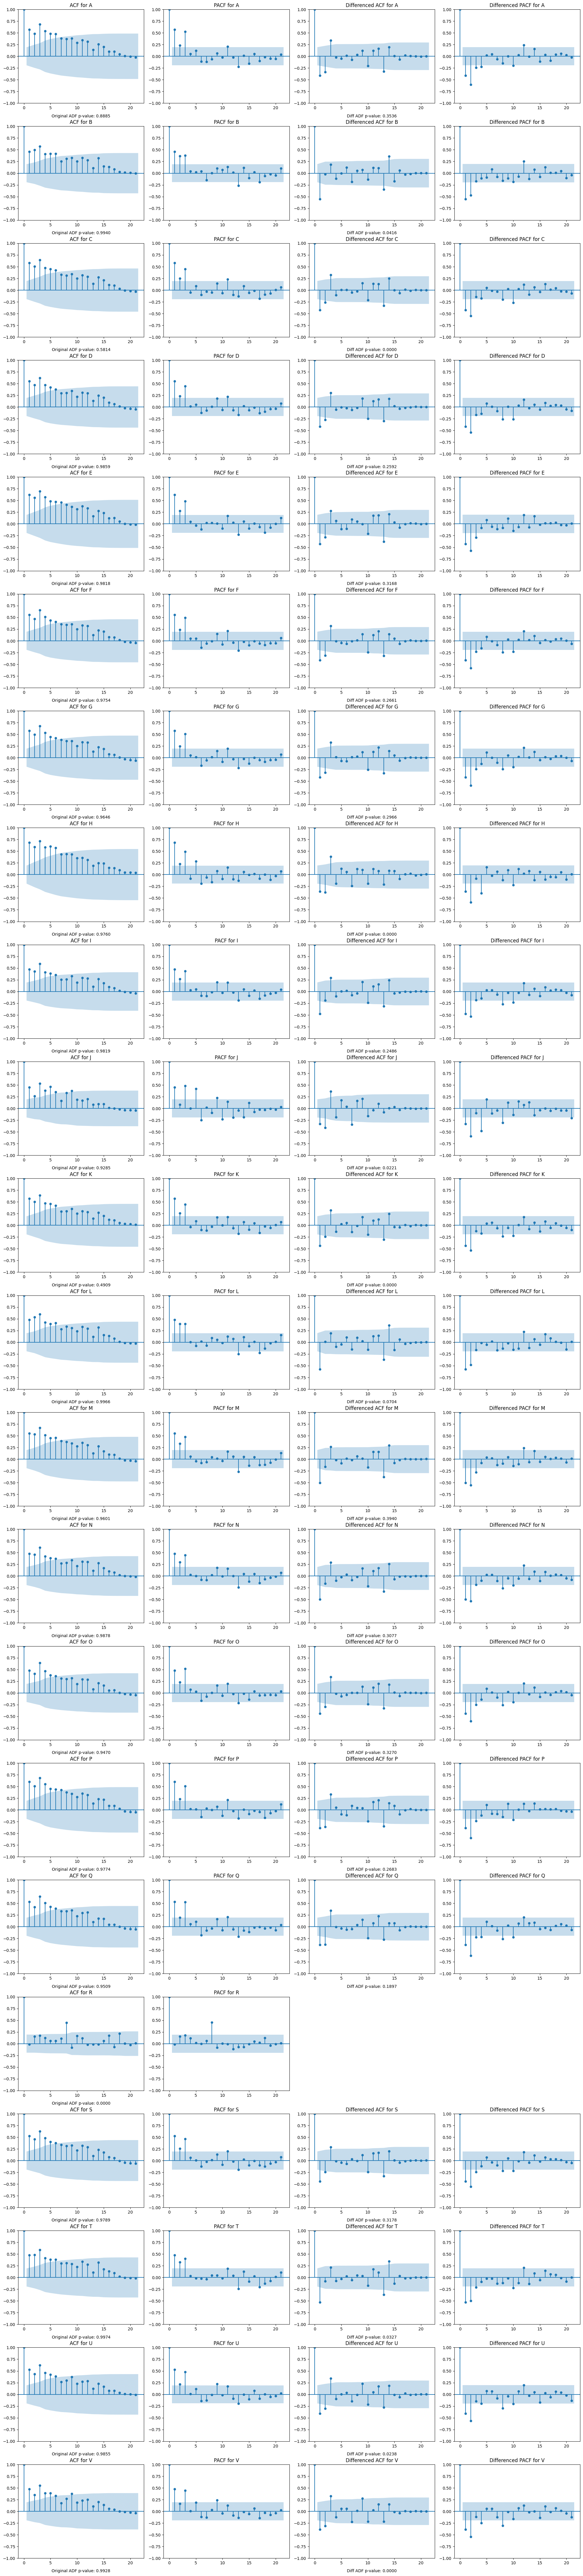

In [40]:
reg_stationarity_acf_pacf(df_corr_reg_cleaned, 'acf_pacf_regions_corr')


## Building of the final models : Regional Level

# Random Forest Algorithm

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model
- Feature Extraction : Using RandomForestRegressor, extracting the 7 most important keywords (set arbitrarly) ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on n_estimators and max_depth ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality

In [41]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    # Feature Extraction by using past week keywords queries (choose the 7 first)
    rf = RandomForestRegressor(random_state=0, max_depth = 16, n_estimators = 200).fit(df_reg_cleaned[region]['x'], np.array(df_reg_cleaned[region]['y']).ravel())
    important_features = pd.Series(rf.feature_importances_, index=df_reg_cleaned[region]['x'].columns).nlargest(7)

    print(f'Important features (feature extraction) for {region} (in addition to seasonality) : \n{important_features}')

    selected_features = important_features.index.tolist()
    season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
    for season in season_columns:
        if season not in selected_features:
            selected_features.append(season)

    df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'][selected_features]

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        rf_model = RandomForestRegressor(random_state=17)
        algorithm_params = {'n_estimators': [100, 200, 300],
                            'max_depth': [None, 10, 20, 30]}
        grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(x_train_scaled, y_train_scaled.ravel())

        y_pred = grid_search.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Important features (feature extraction) for A (in addition to seasonality) : 
fievre             0.568141
covid symptômes    0.132480
covid symptomes    0.055416
fièvre             0.040505
covid              0.024583
vomissement        0.023006
coronavirus        0.022017
dtype: float64
Region A, Lag 1, Mse: 0.5984204260351981
Region A, Lag 2, Mse: 0.5669868665156759
Region A, Lag 3, Mse: 0.7997941323612219
Region A, Lag 4, Mse: 0.9267470386882453
Region A, Lag 5, Mse: 1.0839421136946168
Important features (feature extraction) for B (in addition to seasonality) : 
covid symptômes    0.550178
fievre             0.121573
mal de tete        0.080954
covid symptomes    0.066669
vomissement        0.031027
coronavirus        0.014488
toux               0.012269
dtype: float64
Region B, Lag 1, Mse: 0.7827836642048451
Region B, Lag 2, Mse: 0.8333331938643073
Region B, Lag 3, Mse: 0.7619707579390811
Region B, Lag 4, Mse: 0.6551286065727312
Region B, Lag 5, Mse: 0.6436838173985915
Important fe

Plotting the results : Only the best model and its associated lag and MSE for each region

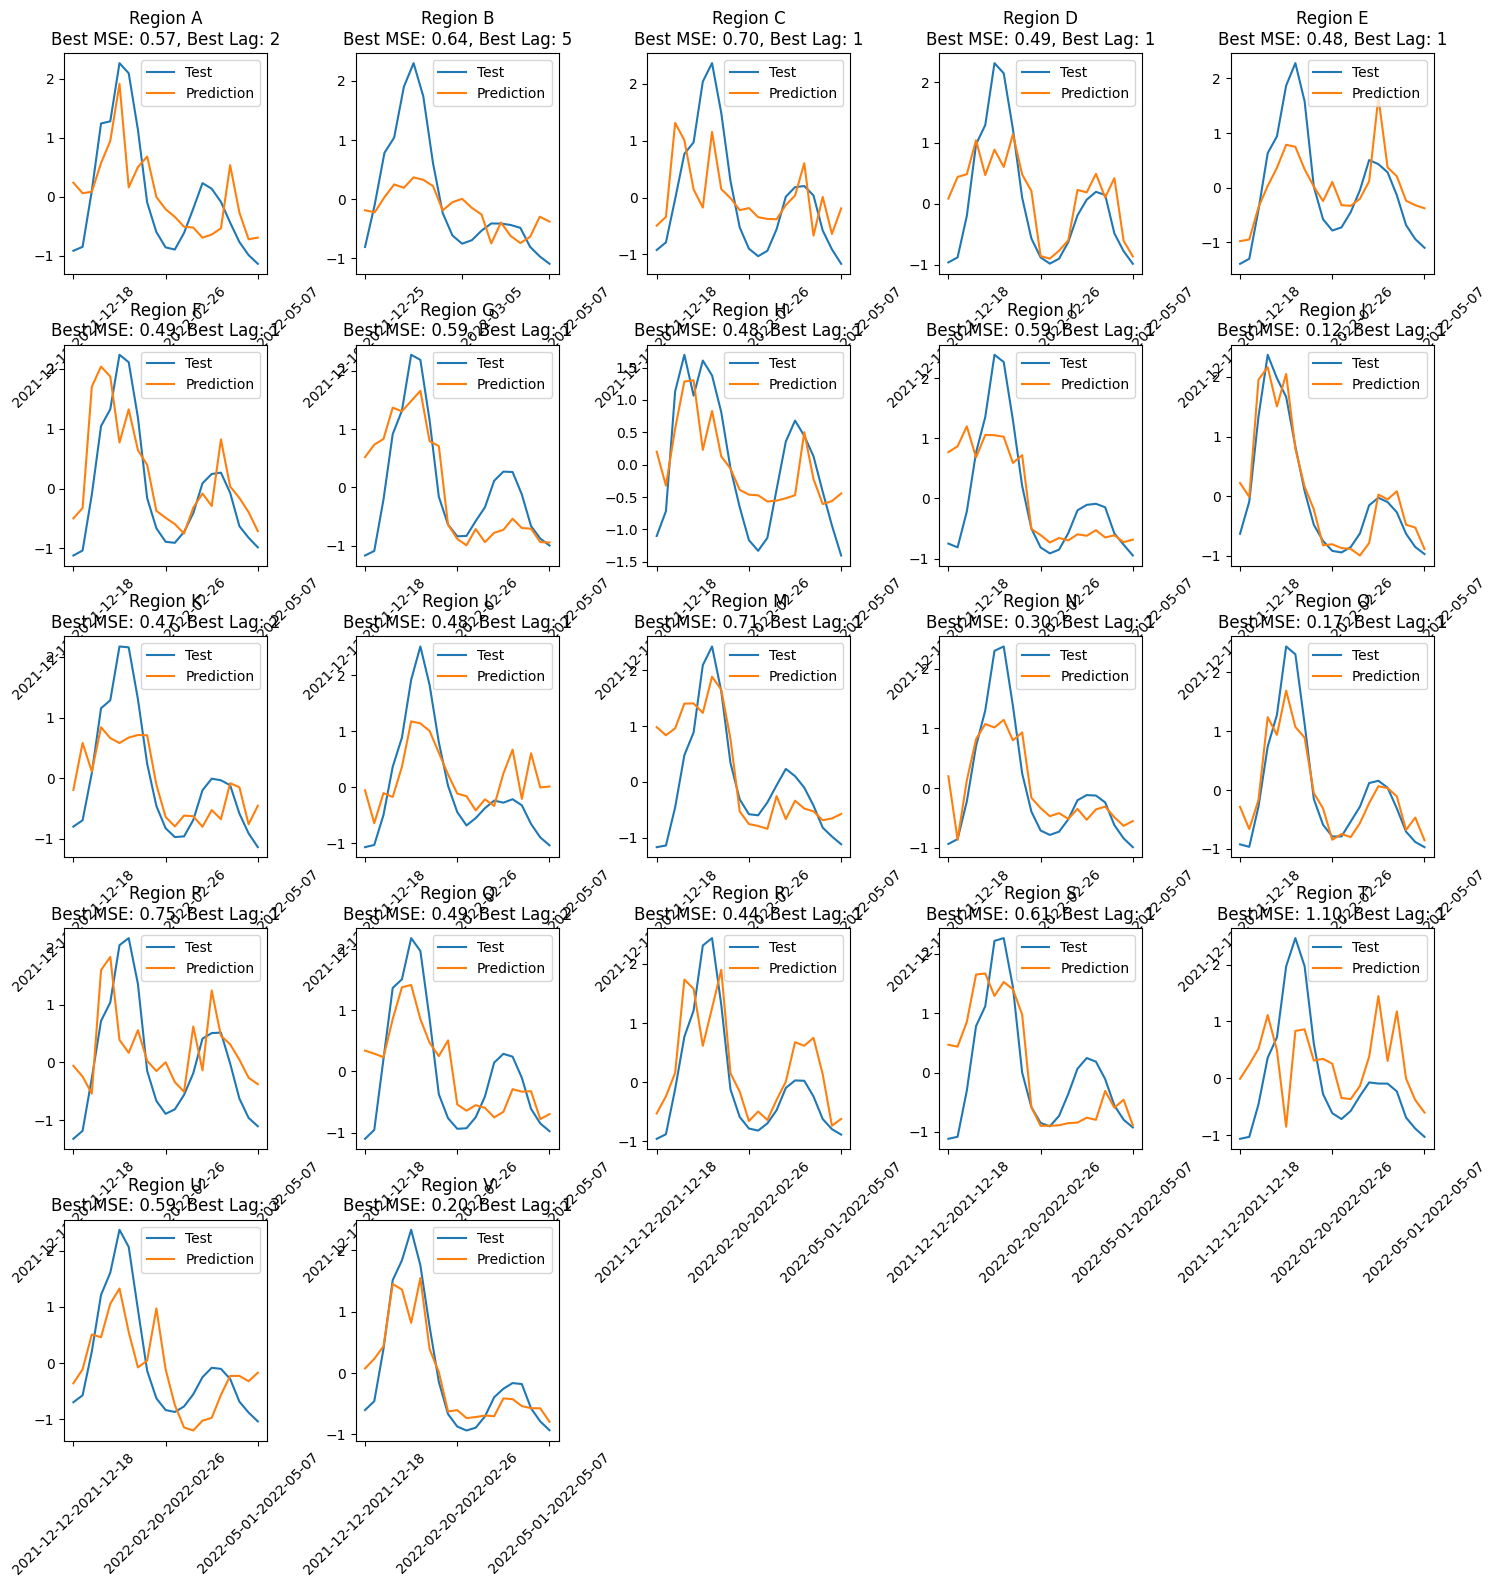

In [42]:
region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='rf_no_ar_reg')

## Building of the final models : Regional Level

# LASSO Model

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on alphas ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality


In [46]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        rf_model = LassoCV(random_state=17)
        algorithm_params = {'alphas': [[0.02], [0.03]]}
        grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(x_train_scaled, y_train_scaled.ravel())

        y_pred = grid_search.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Region A, Lag 1, Mse: 0.4357320275598432
Region A, Lag 2, Mse: 0.8266404850238439
Region A, Lag 3, Mse: 1.0695968262492337
Region A, Lag 4, Mse: 1.1331969591717372
Region A, Lag 5, Mse: 0.9943039975007117
Region B, Lag 1, Mse: 0.7490349766288099
Region B, Lag 2, Mse: 0.9718194083186023
Region B, Lag 3, Mse: 1.0380609471760138
Region B, Lag 4, Mse: 0.8185571358855146
Region B, Lag 5, Mse: 0.6038757071014069
Region C, Lag 1, Mse: 0.8998592091831282
Region C, Lag 2, Mse: 0.7337608556306736
Region C, Lag 3, Mse: 0.7347177671388633
Region C, Lag 4, Mse: 0.921078100415102
Region C, Lag 5, Mse: 1.186990875849537
Region D, Lag 1, Mse: 0.42190109025820516
Region D, Lag 2, Mse: 0.7846818012402599
Region D, Lag 3, Mse: 1.0326713929875329
Region D, Lag 4, Mse: 1.2093941137022497
Region D, Lag 5, Mse: 1.1164537193379391
Region E, Lag 1, Mse: 0.7454800962080949
Region E, Lag 2, Mse: 0.9643236153545421
Region E, Lag 3, Mse: 1.2904661354883786
Region E, Lag 4, Mse: 1.5185752876220335
Region E, Lag 5, 

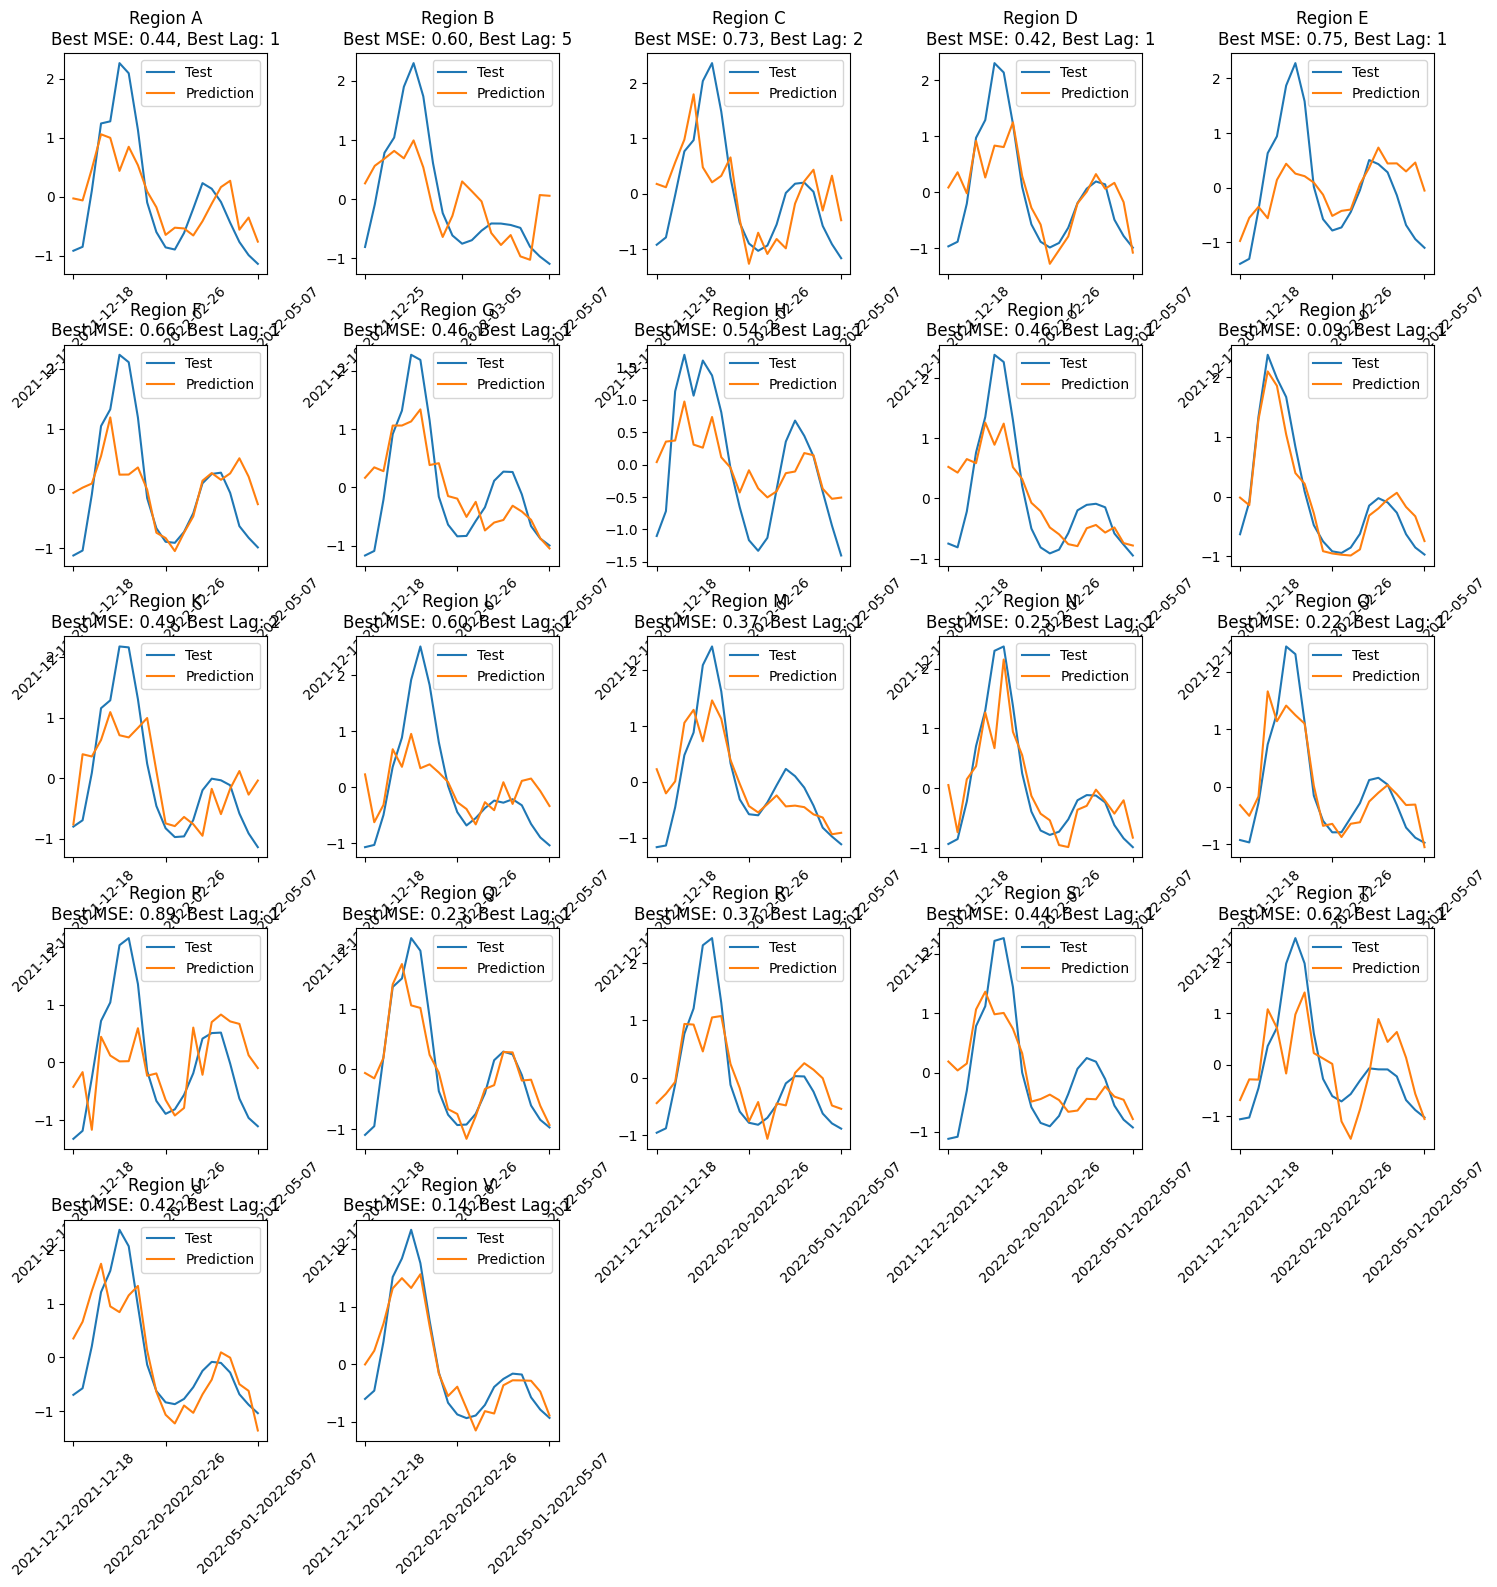

In [47]:
# Plotting

region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='lasso_no_ar_reg')

## Building of the final models : Regional Level

# Benchmark Model : Linear Regression

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the 1st lag as it's always the best

- No Feature Extraction ;
- No Cross Validation ;
- No Resampling Method ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality

In [48]:
scaler = StandardScaler()
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        lr_model = LinearRegression().fit(x_train_scaled, y_train_scaled)
        y_pred = lr_model.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Region A, Lag 1, Mse: 0.44195212759022307
Region A, Lag 2, Mse: 0.8557439688514233
Region A, Lag 3, Mse: 1.0948900704562026
Region A, Lag 4, Mse: 1.160558365683671
Region A, Lag 5, Mse: 0.980803093168961
Region B, Lag 1, Mse: 0.7872697918502342
Region B, Lag 2, Mse: 1.0206475488623479
Region B, Lag 3, Mse: 1.1353017782032484
Region B, Lag 4, Mse: 0.8752080074539723
Region B, Lag 5, Mse: 0.5912441049088778
Region C, Lag 1, Mse: 1.0974061926678498
Region C, Lag 2, Mse: 0.8600756868030727
Region C, Lag 3, Mse: 0.7783840396148937
Region C, Lag 4, Mse: 0.8818627381829156
Region C, Lag 5, Mse: 1.1617188923281572
Region D, Lag 1, Mse: 0.4311008123301562
Region D, Lag 2, Mse: 0.7847197673472428
Region D, Lag 3, Mse: 1.013091749168412
Region D, Lag 4, Mse: 1.1755948527963442
Region D, Lag 5, Mse: 1.086828090731008
Region E, Lag 1, Mse: 0.8105056427449294
Region E, Lag 2, Mse: 1.1011242259593101
Region E, Lag 3, Mse: 1.3124125164854157
Region E, Lag 4, Mse: 1.483593374987658
Region E, Lag 5, Mse

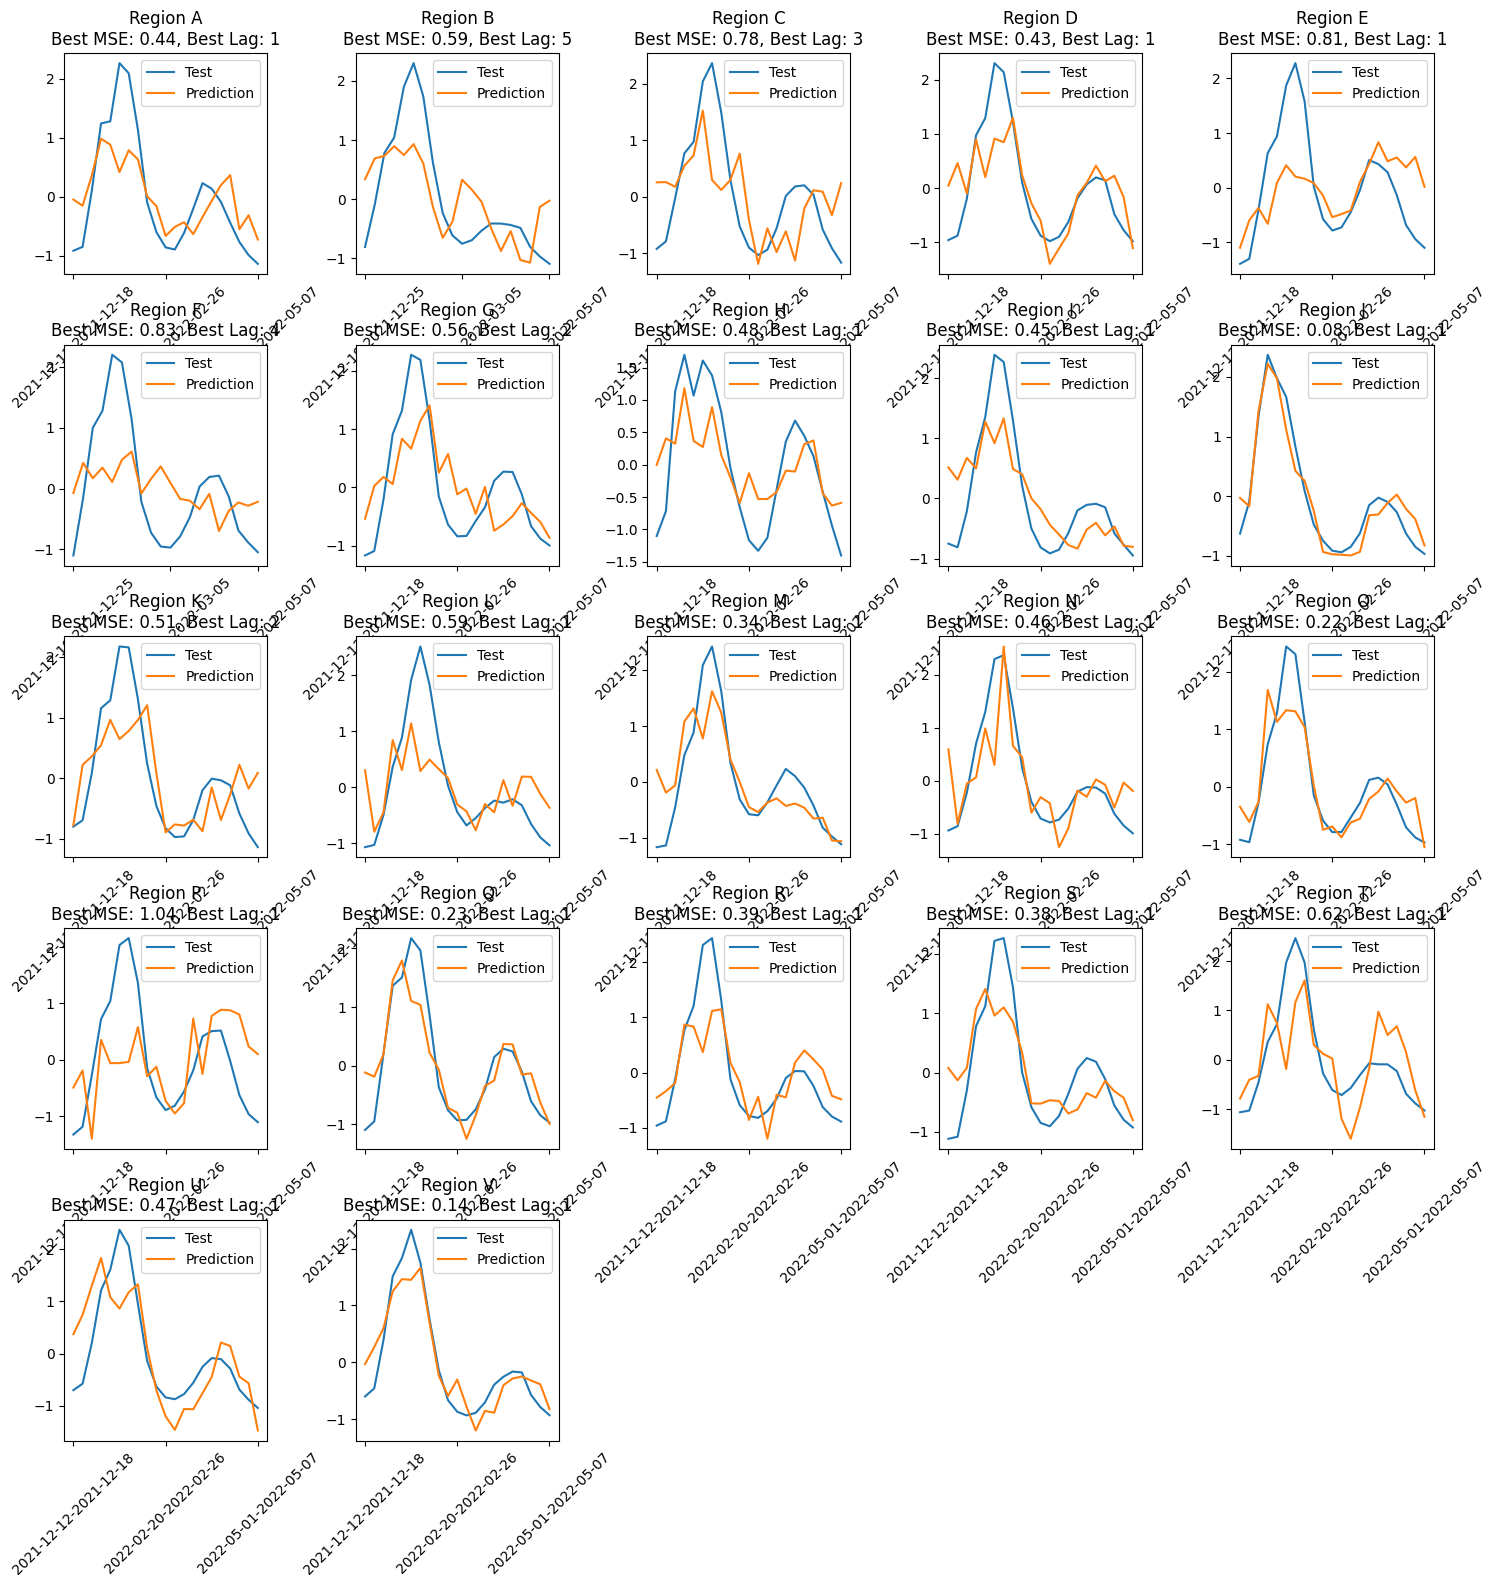

In [49]:
# Plotting

region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='bm_no_ar_reg')

## Building of the final models : Regional Level

# Bonus : Random Forest Model (Autoregressive part)

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on alphas ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality + AR(2) of Ti

In [60]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    # Feature Extraction by using past week keywords queries (choose the 7 first)
    rf = RandomForestRegressor(random_state=0, max_depth = 16, n_estimators = 200).fit(df_reg_cleaned[region]['x'], np.array(df_reg_cleaned[region]['y']).ravel())
    important_features = pd.Series(rf.feature_importances_, index=df_reg_cleaned[region]['x'].columns).nlargest(7)

    print(f'Important features (feature extraction) for {region} (in addition to past values of Ti) : \n{important_features}')

    selected_features = important_features.index.tolist()
    season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
    for season in season_columns:
        if season not in selected_features:
            selected_features.append(season)

    df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'][selected_features]

    # Add past values of Ti as explanatory variables (2 lags for all regions, except for H according to the graphs)
    if region != 'H':
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x']['Ti_2'] = df_reg_cleaned[region]['y'].shift(2)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[2:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[2:]
    else:
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[1:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[1:]

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        rf_model = RandomForestRegressor(random_state=17)
        algorithm_params = {'n_estimators': [100, 200, 300],
                            'max_depth': [None, 10, 20, 30]}
        grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(x_train_scaled, y_train_scaled.ravel())

        y_pred = grid_search.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Important features (feature extraction) for A (in addition to past values of Ti) : 
fievre             0.568141
covid symptômes    0.132480
covid symptomes    0.055416
fièvre             0.040505
covid              0.024583
vomissement        0.023006
coronavirus        0.022017
dtype: float64
Region A, Lag 1, Mse: 0.30705977344971164
Region A, Lag 2, Mse: 0.8192027235484286
Region A, Lag 3, Mse: 0.7440297214748087
Region A, Lag 4, Mse: 0.9228888346952043
Region A, Lag 5, Mse: 0.6848254196740224
Important features (feature extraction) for B (in addition to past values of Ti) : 
covid symptômes    0.550178
fievre             0.121573
mal de tete        0.080954
covid symptomes    0.066669
vomissement        0.031027
coronavirus        0.014488
toux               0.012269
dtype: float64
Region B, Lag 1, Mse: 0.1966990376799642
Region B, Lag 2, Mse: 0.5341034055635179
Region B, Lag 3, Mse: 0.568900228632241
Region B, Lag 4, Mse: 0.5004261909028079
Region B, Lag 5, Mse: 0.5031237464901318


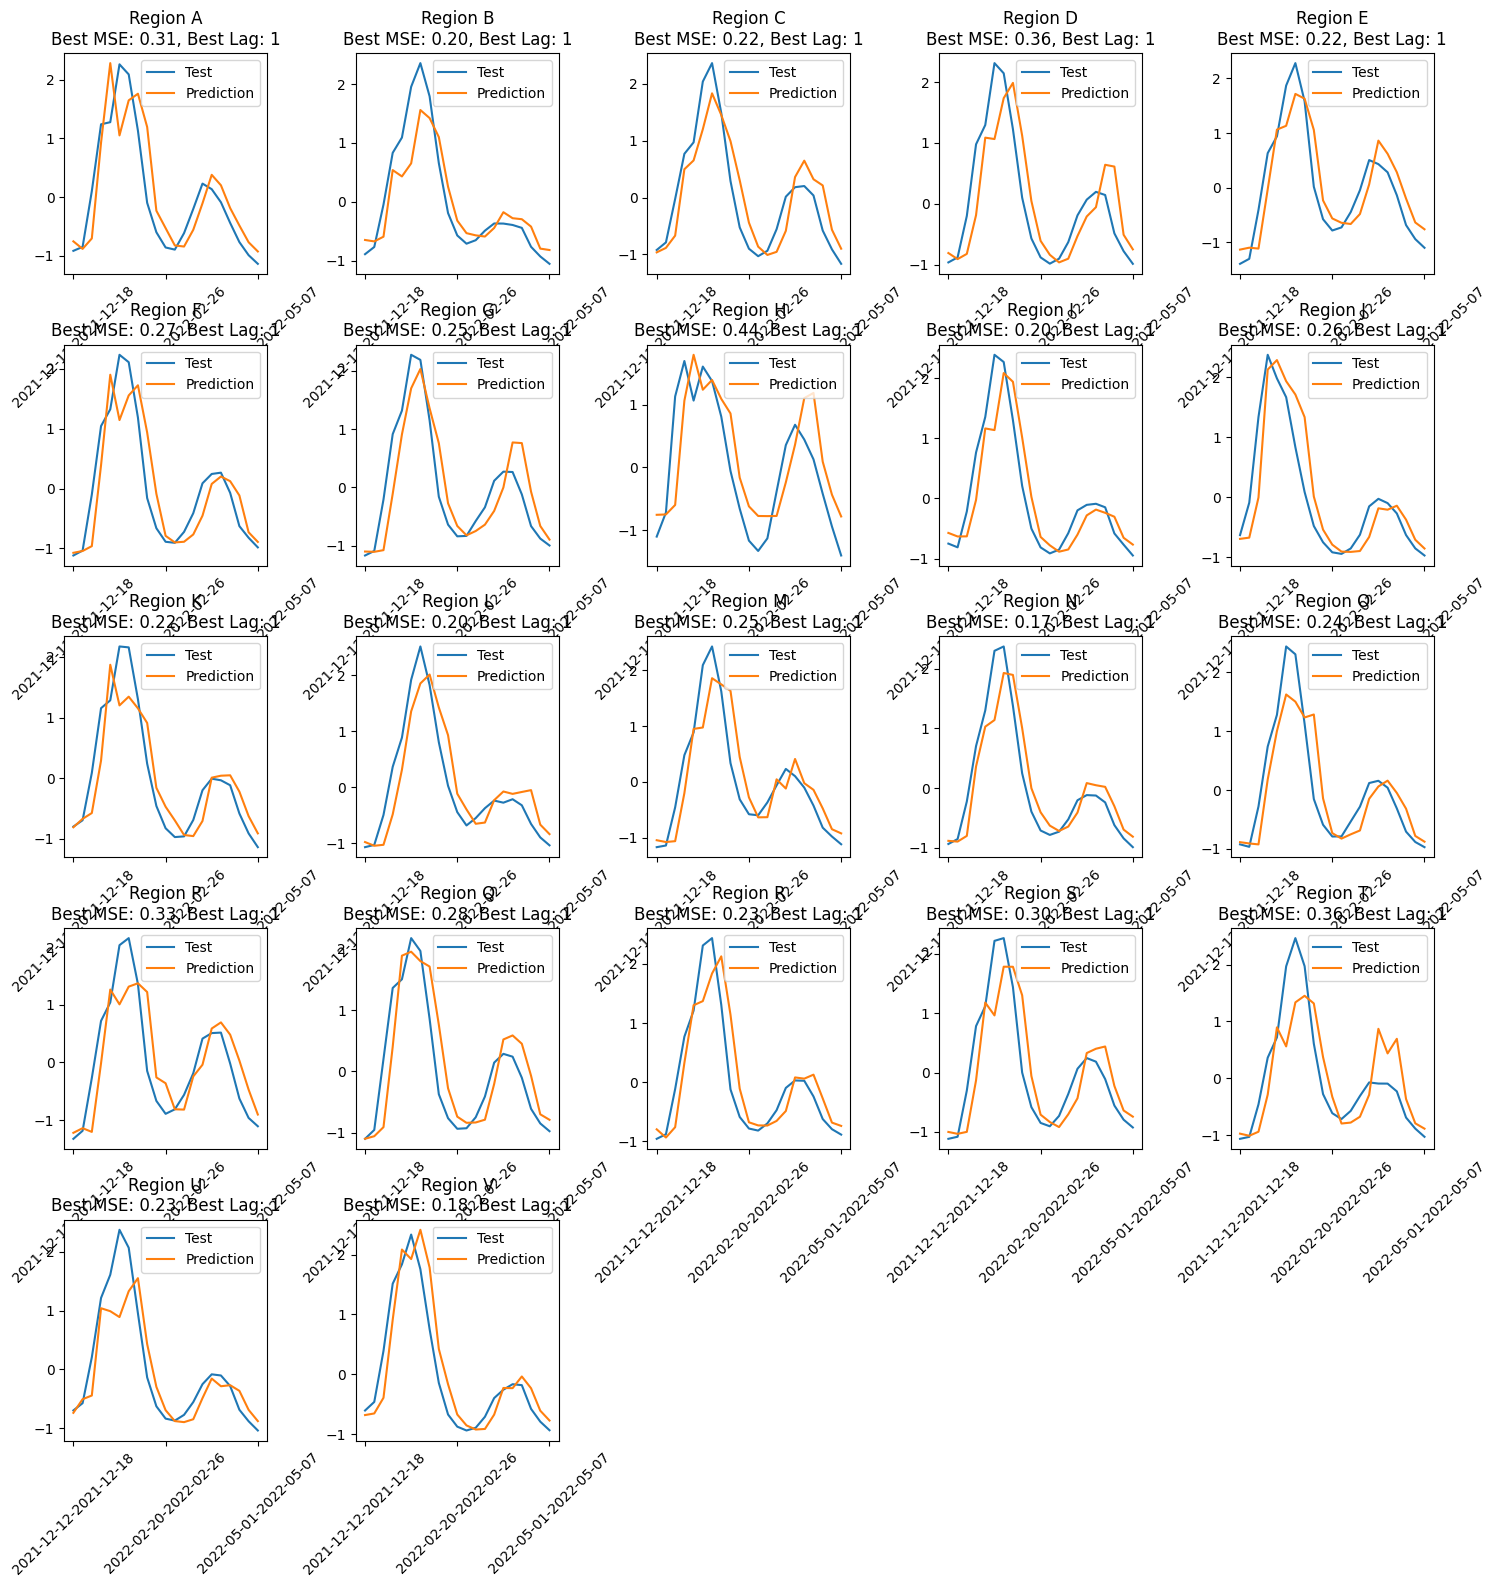

In [61]:
# Plotting

region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='rf_ar_reg')

## Building of the final models : Regional Level

# Bonus : LASSO Model (Autoregressive Part)

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on alphas ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality + AR(2) of Ti

In [70]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    # Add past values of Ti as explanatory variables (2 lags for all regions, except for H according to the graphs)
    if region != 'H':
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x']['Ti_2'] = df_reg_cleaned[region]['y'].shift(2)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[2:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[2:]
    else:
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[1:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[1:]

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        rf_model = LassoCV(random_state=17)
        algorithm_params = {'alphas': [[0.02], [0.03]]}
        grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(x_train_scaled, y_train_scaled.ravel())

        y_pred = grid_search.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Region A, Lag 1, Mse: 0.26463357124556525
Region A, Lag 2, Mse: 0.7572760963474764
Region A, Lag 3, Mse: 1.1750922027197999
Region A, Lag 4, Mse: 1.314496157965335
Region A, Lag 5, Mse: 1.1640965514285346
Region B, Lag 1, Mse: 0.19991051474201518
Region B, Lag 2, Mse: 0.8144769531260738
Region B, Lag 3, Mse: 1.2027556652672815
Region B, Lag 4, Mse: 0.7443198444337854
Region B, Lag 5, Mse: 0.5781535803914143
Region C, Lag 1, Mse: 0.23657666766198254
Region C, Lag 2, Mse: 0.6814725577079189
Region C, Lag 3, Mse: 0.836481313944183
Region C, Lag 4, Mse: 1.2148736766482808
Region C, Lag 5, Mse: 1.2202832416474796
Region D, Lag 1, Mse: 0.21017984407451426
Region D, Lag 2, Mse: 0.6557379241346409
Region D, Lag 3, Mse: 1.2456053815934056
Region D, Lag 4, Mse: 1.4238117844143607
Region D, Lag 5, Mse: 0.9743640924617798
Region E, Lag 1, Mse: 0.2374377777337825
Region E, Lag 2, Mse: 0.9143552234037658
Region E, Lag 3, Mse: 1.6537783961044965
Region E, Lag 4, Mse: 1.6755179649061192
Region E, Lag 

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.297e-04, tolerance: 8.277e-04
  model = cd_fast.enet_coordinate_descent(


Region F, Lag 5, Mse: 1.1215017548938035
Region G, Lag 1, Mse: 0.2757513273649614
Region G, Lag 2, Mse: 0.858221794365431
Region G, Lag 3, Mse: 1.5771646332344713
Region G, Lag 4, Mse: 1.9812774758482206
Region G, Lag 5, Mse: 2.2533183997489212
Region H, Lag 1, Mse: 0.3249920233647667
Region H, Lag 2, Mse: 0.8098113832921351
Region H, Lag 3, Mse: 1.5260399554224797
Region H, Lag 4, Mse: 1.257336363355853
Region H, Lag 5, Mse: 1.2123152418745504
Region I, Lag 1, Mse: 0.16227187935503076
Region I, Lag 2, Mse: 0.6373803847616676
Region I, Lag 3, Mse: 1.159457389154713
Region I, Lag 4, Mse: 1.1840940579605297


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e-03, tolerance: 3.148e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.934e-03, tolerance: 3.148e-03
  model = cd_fast.enet_coordinate_descent(


Region I, Lag 5, Mse: 1.4777705497868676
Region J, Lag 1, Mse: 0.19275111834156144
Region J, Lag 2, Mse: 0.7123958511581315
Region J, Lag 3, Mse: 1.0884449651688899
Region J, Lag 4, Mse: 1.6862781743872184
Region J, Lag 5, Mse: 1.9942621439410952
Region K, Lag 1, Mse: 0.2011985135463839
Region K, Lag 2, Mse: 0.8076684137725051
Region K, Lag 3, Mse: 1.5309328924177414
Region K, Lag 4, Mse: 1.2316635650946428
Region K, Lag 5, Mse: 0.6259207787697314
Region L, Lag 1, Mse: 0.2170336641794231
Region L, Lag 2, Mse: 1.0660811890184727
Region L, Lag 3, Mse: 1.9492520624336513
Region L, Lag 4, Mse: 2.0500274759507002
Region L, Lag 5, Mse: 1.5479975757925242
Region M, Lag 1, Mse: 0.30247121048922043
Region M, Lag 2, Mse: 0.9662694984419369
Region M, Lag 3, Mse: 1.2907924361272571
Region M, Lag 4, Mse: 1.2355091389624737
Region M, Lag 5, Mse: 0.9772069484783378
Region N, Lag 1, Mse: 0.10649278166131403
Region N, Lag 2, Mse: 0.3211113746430311
Region N, Lag 3, Mse: 0.6474846111117862
Region N, Lag

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e-03, tolerance: 1.944e-03
  model = cd_fast.enet_coordinate_descent(


Region O, Lag 1, Mse: 0.200846563382883
Region O, Lag 2, Mse: 0.6965991888489688
Region O, Lag 3, Mse: 1.0986629876583545


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.464e-03, tolerance: 3.172e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e-03, tolerance: 1.493e-03
  model = cd_fast.enet_coordinate_descent(


Region O, Lag 4, Mse: 1.3627823098765597
Region O, Lag 5, Mse: 1.6806848650873363
Region P, Lag 1, Mse: 0.30248365418561735
Region P, Lag 2, Mse: 1.2155053494504857
Region P, Lag 3, Mse: 1.9357302236532317
Region P, Lag 4, Mse: 2.079389465160701
Region P, Lag 5, Mse: 1.800621186703974
Region Q, Lag 1, Mse: 0.3454690085850932
Region Q, Lag 2, Mse: 1.1450406950688055
Region Q, Lag 3, Mse: 1.6035461429722768
Region Q, Lag 4, Mse: 1.9424728628283572
Region Q, Lag 5, Mse: 1.5293459069015327
Region R, Lag 1, Mse: 0.18721835128119108
Region R, Lag 2, Mse: 0.6513240626539576
Region R, Lag 3, Mse: 0.9435180553291154
Region R, Lag 4, Mse: 1.2436938342566077
Region R, Lag 5, Mse: 1.296486257069645
Region S, Lag 1, Mse: 0.33603271336134477
Region S, Lag 2, Mse: 0.9556562992097541
Region S, Lag 3, Mse: 1.3726282572641202
Region S, Lag 4, Mse: 1.5320406625289107
Region S, Lag 5, Mse: 1.232847425796313
Region T, Lag 1, Mse: 0.3001581417143032
Region T, Lag 2, Mse: 0.9067545431616402
Region T, Lag 3, 

c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.614e-03, tolerance: 4.664e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.891e-03, tolerance: 3.561e-03
  model = cd_fast.enet_coordinate_descent(


Region V, Lag 2, Mse: 0.6468583295029685
Region V, Lag 3, Mse: 1.243539643625315
Region V, Lag 4, Mse: 0.7325659716714926
Region V, Lag 5, Mse: 0.7444981252635744


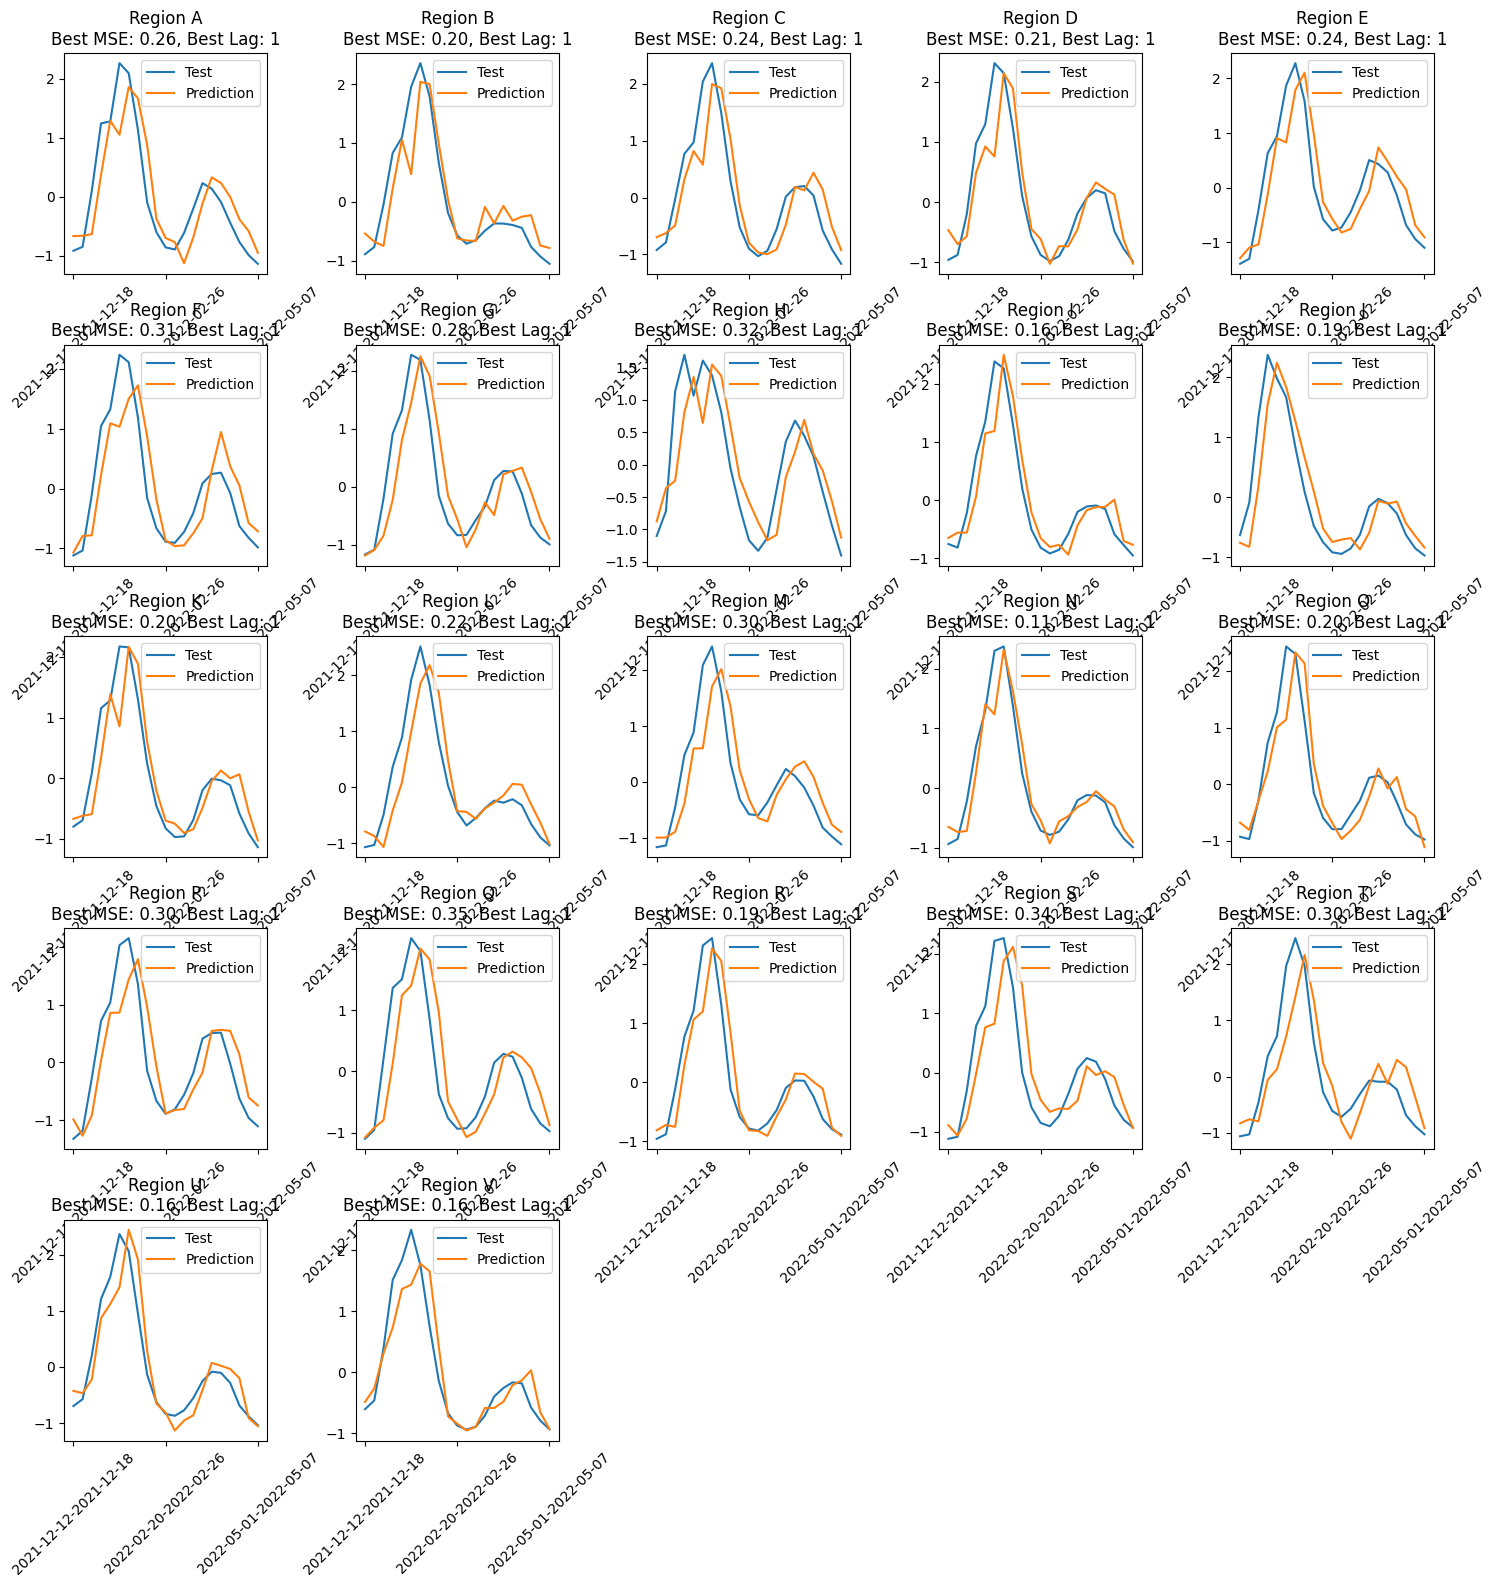

In [71]:
# Plotting

region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='lasso_ar_reg')

## Building of the final models : Regional Level

# Bonus : Benchmark Model (Autoregressive Part)

For each region we :   
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the 1st lag : always the best

- No Feature Extraction : automatically done by the model ;
- No Cross Validation ;
- No Resampling Method ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality + AR(2) of Ti

In [72]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_reg_cleaned.keys():
    results[region] = {}

    # Add past values of Ti as explanatory variables (2 lags for all regions, except for H according to the graphs)
    if region != 'H':
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x']['Ti_2'] = df_reg_cleaned[region]['y'].shift(2)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[2:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[2:]
    else:
        df_reg_cleaned[region]['x']['Ti_1'] = df_reg_cleaned[region]['y'].shift(1)
        df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'].iloc[1:]
        df_reg_cleaned[region]['y'] = df_reg_cleaned[region]['y'].iloc[1:]

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling
        X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        lr_model = LinearRegression().fit(x_train_scaled, y_train_scaled)
        y_pred = lr_model.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Region A, Lag 1, Mse: 0.8238880176245639
Region A, Lag 2, Mse: 3.073527556649193
Region A, Lag 3, Mse: 4.175811605048501
Region A, Lag 4, Mse: 5.846720151933359
Region A, Lag 5, Mse: 8.923356476744065
Region B, Lag 1, Mse: 1.1501709678118546
Region B, Lag 2, Mse: 5.405593521388262
Region B, Lag 3, Mse: 12.221880015542913
Region B, Lag 4, Mse: 26.28024168890068
Region B, Lag 5, Mse: 24.45163244521201
Region C, Lag 1, Mse: 5.748925699345168e+21
Region C, Lag 2, Mse: 2.0605632941986674
Region C, Lag 3, Mse: 4.876284830973312
Region C, Lag 4, Mse: 5.235173567474253
Region C, Lag 5, Mse: 5.295007176350567
Region D, Lag 1, Mse: 0.5610684657876448
Region D, Lag 2, Mse: 2.02501017439693
Region D, Lag 3, Mse: 3.860541988563961e+25
Region D, Lag 4, Mse: 5.223017901376529
Region D, Lag 5, Mse: 4.074339912155435
Region E, Lag 1, Mse: 1.30779597887655
Region E, Lag 2, Mse: 3.1355423654103527
Region E, Lag 3, Mse: 8.322528125500371
Region E, Lag 4, Mse: 14.793271899993062
Region E, Lag 5, Mse: 12.17

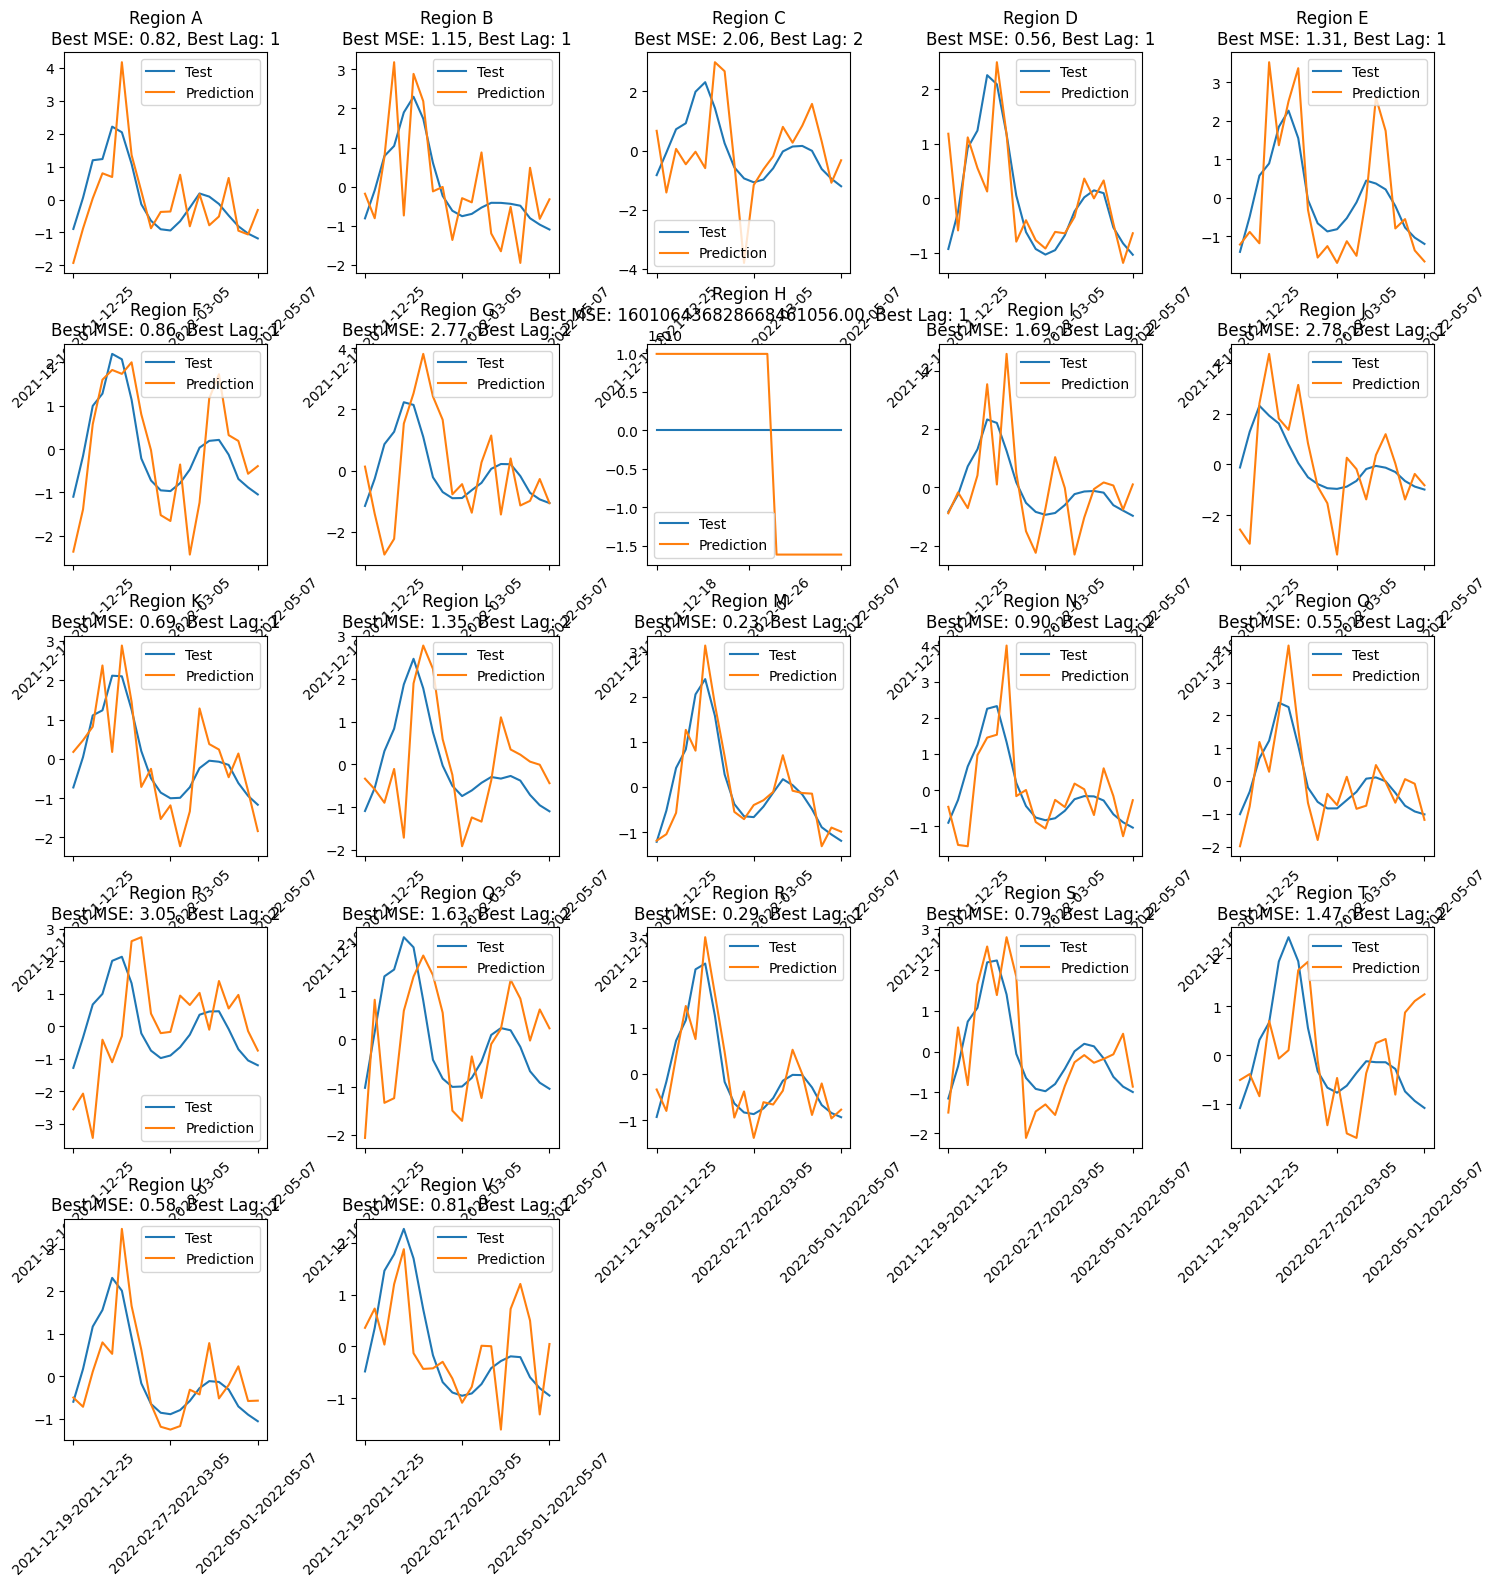

In [73]:
# Plotting

region_names = list(df_reg_cleaned.keys())
plot_results(regions=region_names, results=results, filename='bm_ar_reg')

Potential data leakage :

- Overall results for keywords are standardized on the whole period ;
- This is a strong issue for ML and Policy Making : we should not know anything from the test set ;
- Solution :
  - Extract train/test sets separately to avoid data leakage on the test set ;
  - Compute models, adding Autoregressive Part of the Ti (lag 2).

In [20]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for region in df_corr_reg_cleaned.keys():
    results[region] = {}

    # Feature Extraction by using past week keywords queries (choose the 7 first)
    rf = RandomForestRegressor(random_state=0, max_depth = 16, n_estimators = 200).fit(df_corr_reg_cleaned[region]['x'], np.array(df_corr_reg_cleaned[region]['y']).ravel())
    important_features = pd.Series(rf.feature_importances_, index=df_corr_reg_cleaned[region]['x'].columns).nlargest(7)

    print(f'Important features (feature extraction) for {region} (in addition to past values of Ti) : \n{important_features}')

    selected_features = important_features.index.tolist()
    season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
    for season in season_columns:
        if season not in selected_features:
            selected_features.append(season)

    df_corr_reg_cleaned[region]['x'] = df_corr_reg_cleaned[region]['x'][selected_features]

    # Add past values of Ti as explanatory variables (2 lags for all regions, except for H according to the graphs)
    if region != 'H':
        df_corr_reg_cleaned[region]['x']['Ti_1'] = df_corr_reg_cleaned[region]['y'].shift(1)
        df_corr_reg_cleaned[region]['x']['Ti_2'] = df_corr_reg_cleaned[region]['y'].shift(2)
        df_corr_reg_cleaned[region]['x'] = df_corr_reg_cleaned[region]['x'].iloc[2:]
        df_corr_reg_cleaned[region]['y'] = df_corr_reg_cleaned[region]['y'].iloc[2:]
    else:
        df_corr_reg_cleaned[region]['x']['Ti_1'] = df_corr_reg_cleaned[region]['y'].shift(1)
        df_corr_reg_cleaned[region]['x'] = df_corr_reg_cleaned[region]['x'].iloc[1:]
        df_corr_reg_cleaned[region]['y'] = df_corr_reg_cleaned[region]['y'].iloc[1:]

    for i in range(0, 5):

        # Trying different values for the lag of keywords, adjusting correspondingly the column y
        temp_x = df_corr_reg_cleaned[region]['x'].shift(i).iloc[i:]
        temp_y = df_corr_reg_cleaned[region]['y'].iloc[i:]

        # Splitting and scaling

        X_test = df_corr_reg_cleaned[region]['x'].loc[df_corr_reg_cleaned[region]['test dates']]
        y_test = df_corr_reg_cleaned[region]['y'].loc[df_corr_reg_cleaned[region]['test dates']]
        X_train = df_corr_reg_cleaned[region]['x'].loc[~df_corr_reg_cleaned[region]['x'].index.isin(df_corr_reg_cleaned[region]['test dates'])]
        y_train = df_corr_reg_cleaned[region]['y'].loc[~df_corr_reg_cleaned[region]['y'].index.isin(df_corr_reg_cleaned[region]['test dates'])]


        # Transforming the datasets
        x_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.fit_transform(y_train)
        x_test_scaled = scaler.fit_transform(X_test)
        y_test_scaled = scaler.fit_transform(y_test)

        # Grid Search with Time Series Split cross-validation
        rf_model = RandomForestRegressor(random_state=17)
        algorithm_params = {'n_estimators': [100, 200, 300],
                            'max_depth': [None, 10, 20, 30]}
        grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
        grid_search.fit(x_train_scaled, y_train_scaled.ravel())

        y_pred = grid_search.predict(x_test_scaled)
        acc = metrics.mean_squared_error(y_test_scaled, y_pred)

        results[region][i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
        print(f"Region {region}, Lag {i+1}, Mse: {acc}")

Important features (feature extraction) for A (in addition to past values of Ti) : 
covid symptomes    0.175534
toux               0.147176
nausée             0.112048
coronavirus        0.077101
maux de tête       0.053011
tousser            0.050083
covid              0.049478
dtype: float64
Region A, Lag 1, Mse: 2.375066325251557
Region A, Lag 2, Mse: 2.375066325251557
Region A, Lag 3, Mse: 2.375066325251557
Region A, Lag 4, Mse: 2.375066325251557
Region A, Lag 5, Mse: 2.375066325251557
Important features (feature extraction) for B (in addition to past values of Ti) : 
covid symptomes    0.244316
mal de tete        0.187610
covid symptômes    0.074908
coronavirus        0.055680
fievre             0.036807
covid19            0.031494
fatigue            0.026822
dtype: float64
Region B, Lag 1, Mse: 1.7292094575089858
Region B, Lag 2, Mse: 1.7292094575089858
Region B, Lag 3, Mse: 1.7292094575089858
Region B, Lag 4, Mse: 1.7292094575089858
Region B, Lag 5, Mse: 1.7292094575089858
Impor

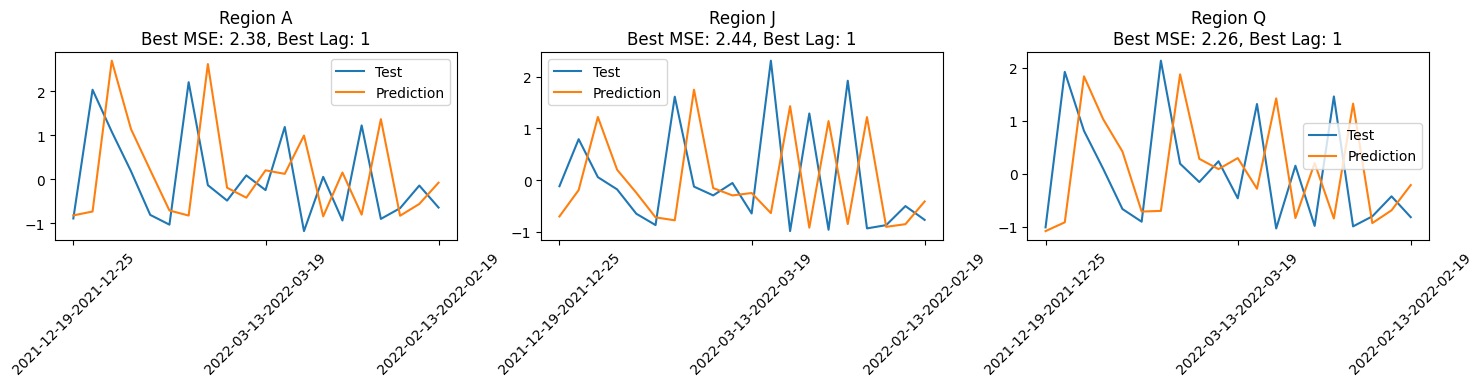

In [21]:
# Plotting

region_names = list(df_corr_reg_cleaned.keys())
plot_results(regions=['A', 'J', 'Q'], results=results, filename='rf_dl_reg')

# Do our results hold at the National Level ?

## Building of the final models : National Level

# Random Forest Model

- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on alphas ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality

In [83]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

# Feature Extraction by using past week keywords queries (choose the 7 first)
rf = RandomForestRegressor(random_state=0, max_depth = 16, n_estimators = 200).fit(x_df, np.array(y_df).ravel())
important_features = pd.Series(rf.feature_importances_, index=x_df.columns).nlargest(7)

print(f'Important features (in addition to past values of Ti) : \n{important_features}')

selected_features = important_features.index.tolist()
season_columns = ['season_autumn', 'season_spring', 'season_summer', 'season_winter']
for season in season_columns:
    if season not in selected_features:
        selected_features.append(season)

df_reg_cleaned[region]['x'] = df_reg_cleaned[region]['x'][selected_features]

for i in range(0, 5):

    # Trying different values for the lag of keywords, adjusting correspondingly the column y
    temp_x = x_df.shift(i).iloc[i:]
    temp_y = y_df.iloc[i:]

    # Splitting and scaling
    X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

    # Transforming the datasets
    x_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train)
    x_test_scaled = scaler.fit_transform(X_test)
    y_test_scaled = scaler.fit_transform(y_test)

    # Grid Search with Time Series Split cross-validation
    rf_model = RandomForestRegressor(random_state=17)
    algorithm_params = {'n_estimators': [100, 200, 300],
                            'max_depth': [None, 10, 20, 30]}
    grid_search = GridSearchCV(rf_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(x_train_scaled, y_train_scaled.ravel())

    y_pred = grid_search.predict(x_test_scaled)
    acc = metrics.mean_squared_error(y_test_scaled, y_pred)

    results[i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
    print(f"National level, Lag {i+1}, Mse: {acc}")

Important features (in addition to past values of Ti) : 
nausee            0.253339
fievre            0.191640
vomissements      0.125732
nez qui saigne    0.090361
maux de tête      0.061978
frissons          0.045908
fièvre            0.045390
dtype: float64
National level, Lag 1, Mse: 0.6703520710404847
National level, Lag 2, Mse: 0.6551948184516208
National level, Lag 3, Mse: 0.5868309216133036
National level, Lag 4, Mse: 0.6997884297873946
National level, Lag 5, Mse: 1.0744503140500945


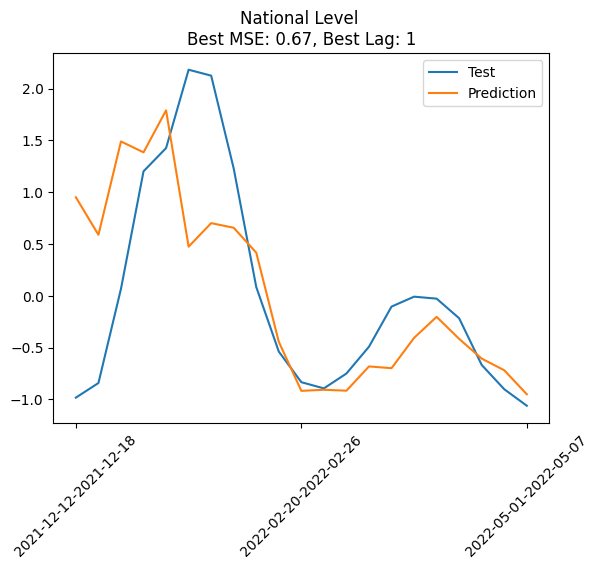

In [84]:
# Plotting

plt.plot(results[0]['Test_idx'], results[0]['true'], label='Test')
plt.plot(results[0]['Test_idx'], results[0]['predictions'], label='Prediction')
plt.title(f'National Level \nBest MSE: {results[0]["mse"]:.2f}, Best Lag: {1}')
plt.legend()
test_index = results[0]['Test_idx']
if len(test_index) > 2:
    first, middle, last = test_index[0], test_index[len(test_index) // 2], test_index[-1]
    plt.xticks([first, middle, last])

plt.xticks(rotation=45)
plt.savefig(f'{output_path}rf_national.png', bbox_inches='tight')
plt.show()

## Building of the final models : National level

# LASSO Model
  
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- Cross Validation : TimeSeriesSplit with 5 Folds ;
- Resampling Method : GridSearchCV on alphas ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality

In [85]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for i in range(0, 5):

    # Trying different values for the lag of keywords, adjusting correspondingly the column y
    temp_x = x_df.shift(i).iloc[i:]
    temp_y = y_df.iloc[i:]

    # Splitting and scaling
    X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

    # Transforming the datasets
    x_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train)
    x_test_scaled = scaler.fit_transform(X_test)
    y_test_scaled = scaler.fit_transform(y_test)

    # Grid Search with Time Series Split cross-validation
    lasso_model = LassoCV(random_state=17)
    algorithm_params = {'alphas': [[0.02], [0.03]]}
    grid_search = GridSearchCV(lasso_model, algorithm_params, cv=tscv, scoring='neg_mean_squared_error')
    grid_search.fit(x_train_scaled, y_train_scaled.ravel())

    y_pred = grid_search.predict(x_test_scaled)
    acc = metrics.mean_squared_error(y_test_scaled, y_pred)

    results[i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
    print(f"National Level, Lag {i+1}, Mse: {acc}")

National Level, Lag 1, Mse: 1.0953951351214601
National Level, Lag 2, Mse: 1.1127942478429513
National Level, Lag 3, Mse: 0.9014072549784703
National Level, Lag 4, Mse: 0.5987076981189096
National Level, Lag 5, Mse: 0.8560689373670403


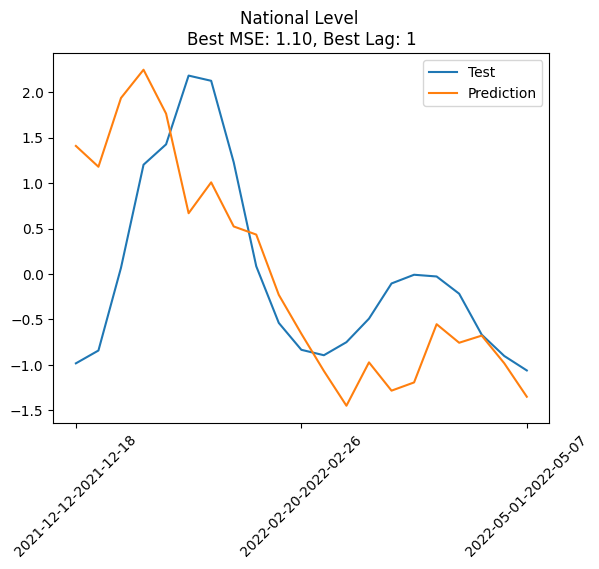

In [86]:
# Plotting

plt.plot(results[0]['Test_idx'], results[0]['true'], label='Test')
plt.plot(results[0]['Test_idx'], results[0]['predictions'], label='Prediction')
plt.title(f'National Level \nBest MSE: {results[0]["mse"]:.2f}, Best Lag: {1}')
plt.legend()
test_index = results[0]['Test_idx']
if len(test_index) > 2:
    first, middle, last = test_index[0], test_index[len(test_index) // 2], test_index[-1]
    plt.xticks([first, middle, last])

plt.xticks(rotation=45)
plt.savefig(f'{output_path}lasso_national.png', bbox_inches='tight')
plt.show()

## Building of the final models : National level

# Benchmark Model
  
- Test different lags for the keywords (between 1 and 5) ;
- Build different models for each lag ;
- Choose the lag exhibiting the smallest MSE as the final model

- No Feature Extraction : automatically done by the model ;
- No Cross Validation ;
- No Resampling Method ;
- Evaluation Metrics : MSE ;
- Target Variable : Ti (Incidence Rate) ;
- Explanatory Variables : Past Keywords + Seasonality

In [87]:
scaler = StandardScaler()
tscv = TimeSeriesSplit(n_splits=5)
results = {}

for i in range(0, 5):

    # Trying different values for the lag of keywords, adjusting correspondingly the column y
    temp_x = x_df.shift(i).iloc[i:]
    temp_y = y_df.iloc[i:]

    # Splitting and scaling
    X_train, X_test, y_train, y_test = train_test_split(temp_x, temp_y, test_size=0.2, random_state=17, shuffle=False)

    # Transforming the datasets
    x_train_scaled = scaler.fit_transform(X_train)
    y_train_scaled = scaler.fit_transform(y_train)
    x_test_scaled = scaler.fit_transform(X_test)
    y_test_scaled = scaler.fit_transform(y_test)

    # Grid Search with Time Series Split cross-validation
    lr_model = LinearRegression().fit(x_train_scaled, y_train_scaled)
    y_pred = lr_model.predict(x_test_scaled)
    acc = metrics.mean_squared_error(y_test_scaled, y_pred)

    results[i] = {'mse': acc, 'predictions': y_pred, 'true' : y_test_scaled, 'Test_idx' : y_test.index}
    print(f"Lag {i+1}, Mse: {acc}")

Lag 1, Mse: 2.708631569003003
Lag 2, Mse: 3.207580487664656
Lag 3, Mse: 4.0768983913779
Lag 4, Mse: 3.7141719002317166
Lag 5, Mse: 4.253521745758056


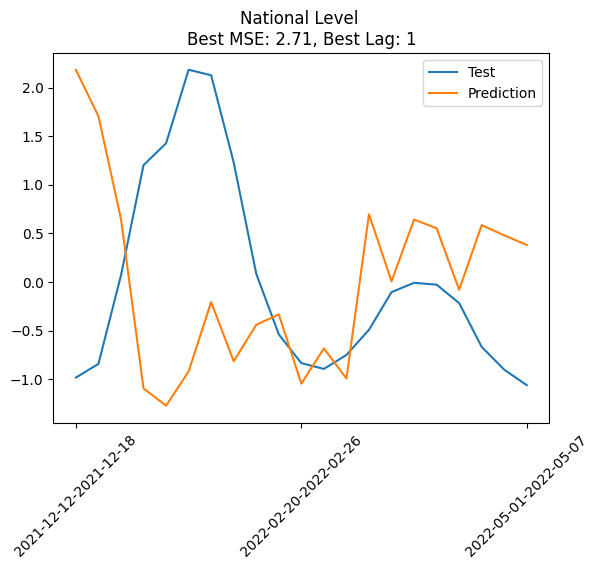

In [88]:
# Plotting

plt.plot(results[0]['Test_idx'], results[0]['true'], label='Test')
plt.plot(results[0]['Test_idx'], results[0]['predictions'], label='Prediction')
plt.title(f'National Level \nBest MSE: {results[0]["mse"]:.2f}, Best Lag: {1}')
plt.legend()
test_index = results[0]['Test_idx']
if len(test_index) > 2:
    first, middle, last = test_index[0], test_index[len(test_index) // 2], test_index[-1]
    plt.xticks([first, middle, last])

plt.xticks(rotation=45)
plt.savefig(f'{output_path}bm_national.png', bbox_inches='tight')
plt.show()